# Проект статистического анализа данных ДТП по регионам России

Заказчиком выступает проект «Карта ДТП» https://dtp-stat.ru/ — некоммерческий проект, посвященный проблеме дорожно-транспортных происшествий в России. На сайте собраны данные о ДТП по всем регионам России за несколько лет. Информация представлена в виде отдельных файлов по регионам и субъектам РФ.

Цель проекта - провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки, разработать дашборд в Datalens для визуального представления статистики и ключевых показателей.

Этапы работы:
1. Загрузка и предобработка данных нескольких регионов, проверка на целостность, пропуски, дубликаты, формат данных.
2. Статистический анализ данных - распределение признаков, корреляция.
3. Формулировка гипотез, выбор методов проверки и сама проверка, выводы.
4. Подготовка данных для использовании на дашборде.
5. Общие выводы.


## Загрузка и предобработка данных

Для начала мы скачали с сайта заказчика файлы данных ДТП по Алтайскому краю и Санкт-Петебургу - будем использовать их для первоначального анализа, после чего настроим автоматизированный анализ с загрузкой данных с сайта в коде.

Файлы (85 регионов, отдельный файл для каждого) имеют расширение .geojson, что говорит о том, что для работы с ними можно попробовать использовать Geopandas. Импортируем необходимые модули и загрузим данные Алтайского края.

In [1]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import io
import re
# from google.collab import drive

import folium
from shapely.geometry import Point


import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import Point, Polygon, shape
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy.stats import norm



# # Отображение всех строк
# pd.set_option('display.max_rows', None)

# # Отображение всех столбцов
# pd.set_option('display.max_columns', None)

# # Отображение полного содержимого ячеек (например, длинных строк)
# pd.set_option('display.max_colwidth', None)

def line():
    print('-' * 50)
    

Скачиваем файлы с сайта заказчика и объединяем их в один

In [2]:

# Монтируем Google Drive
# drive.mount('/content/drive')

# # Путь для сохранения в Google Drive
# drive_output_path = "/content/drive/My Drive/processed_data/all_data_united.geojson"


# Путь для итогового файла
output_path = "all_data_united.geojson"

# Проверяем, существует ли итоговый файл и 
# Проверяем, существует ли итоговый файл в Google Drive

# if os.path.exists(drive_output_path):
#     print(f"Файл {drive_output_path} уже существует. Повторная обработка не требуется.")
if os.path.exists(output_path):
    print(f"Файл {output_path} уже существует. Повторная обработка не требуется.")
else:
    # URL страницы с файлами
    url = "https://dtp-stat.ru/opendata"

    # Скачиваем страницу и извлекаем ссылки на файлы
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        # Ищем ссылки на файлы .geojson
        file_links = [
            a["href"] for a in soup.find_all("a", href=True) if a["href"].endswith(".geojson")
        ]
        print("Найдено ссылок:", len(file_links))
    except requests.RequestException as e:
        print(f"Ошибка при скачивании страницы {url}: {e}")
        file_links = []

    # Список для хранения GeoDataFrames
    all_data_uniteds = []

    # Обработка и объединение всех файлов
    for link in file_links:
        if not link.startswith("http"):
            print(f"Неверный формат ссылки: {link}")
            continue

        filename = link.split("/")[-1]

        # Попробуем скачать файл
        try:
            print(f"Скачиваем файл {filename}...")
            response = requests.get(link, timeout=10)
            response.raise_for_status()

            # Загружаем файл в память как JSON
            data = json.loads(response.text)

            # Исправляем проблемные ключи
            for feature in data["features"]:
                for key in ["tags", "nearby", "weather", "road_conditions", "participant_categories"]:
                    if key in feature["properties"]:
                        feature["properties"][key] = str(feature["properties"][key])  # Преобразуем в строку

            # Преобразуем исправленный JSON в GeoDataFrame
            all_data_united = gpd.GeoDataFrame.from_features(data["features"])
            all_data_uniteds.append(all_data_united)
            print(f"Файл {filename} успешно обработан.")
        except requests.RequestException as e:
            print(f"Ошибка при скачивании {link}: {e}")
        except json.JSONDecodeError as e:
            print(f"Ошибка при обработке JSON файла {filename}: {e}")
        except Exception as e:
            print(f"Неизвестная ошибка при обработке файла {filename}: {e}")

    # Проверяем, есть ли данные для объединения
    if all_data_uniteds:
        try:
            # Объединяем все GeoDataFrames
            all_data_united = gpd.GeoDataFrame(pd.concat(all_data_uniteds, ignore_index=True))

            # Сохраняем объединенный DataFrame на диск
            all_data_united.to_file(output_path, driver="GeoJSON")
            print(f"Объединенные данные сохранены в: {output_path}")

            # Сохраняем файл напрямую в Google Drive
            # os.makedirs(os.path.dirname(drive_output_path), exist_ok=True)
            # all_data_united.to_file(drive_output_path, driver="GeoJSON")
            # print(f"Файл успешно сохранен в Google Drive: {drive_output_path}")

        except Exception as e:
            print(f"Ошибка при объединении или сохранении данных: {e}")
    else:
        print("Нет данных для объединения.")

Файл all_data_united.geojson уже существует. Повторная обработка не требуется.


Добавим загрузку данных из общего файла, если их нет в памяти


In [3]:

if 'all_data_united' not in globals() or all_data_united.empty:

    input_path = "all_data_united.geojson"

    # Шаг 1: Загрузка и обработка GeoJSON в памяти
    try:
        # Загружаем GeoJSON как JSON
        with open(input_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Обрабатываем проблемные поля
        for feature in data["features"]:
            for key in ["tags", "nearby", "weather", "road_conditions", "participant_categories"]:
                if key in feature["properties"]:
                    # Преобразуем в строку или удаляем
                    feature["properties"][key] = str(feature["properties"][key])

        # Проверка геометрии (если требуется)
        for feature in data["features"]:
            try:
                if feature["geometry"] is not None:
                    feature["geometry"] = shape(feature["geometry"]).__geo_interface__
                else:
                    feature["geometry"] = None
            except Exception as e:
                print(f"Ошибка в геометрии: {e}")
                feature["geometry"] = None

        print("Файл успешно обработан в памяти.")

    except Exception as e:
        print(f"Ошибка при обработке файла {input_path}: {e}")
else:
    print('Данные уже в памяти.')

# Шаг 2: Преобразование в GeoDataFrame
try:
    # Преобразуем обратно в GeoJSON-совместимый формат для загрузки в GeoPandas
    all_data_united = gpd.GeoDataFrame.from_features(data["features"])

    # Устанавливаем CRS (если требуется)
    if "crs" in data and "properties" in data["crs"]:
        all_data_united.set_crs(data["crs"]["properties"]["name"], inplace=True)

    # Информация о загруженных данных
    print(all_data_united.info())
    display(all_data_united.sample(3, random_state=42))
    print("Данные успешно загружены.")
except Exception as e:
    print(f"Ошибка при преобразовании в GeoDataFrame: {e}")


Файл успешно обработан в памяти.
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1502773 entries, 0 to 1502772
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   geometry                1492029 non-null  geometry
 1   id                      1502773 non-null  int64   
 2   tags                    1502773 non-null  object  
 3   light                   1502773 non-null  object  
 4   point                   1502773 non-null  object  
 5   nearby                  1502773 non-null  object  
 6   region                  1502773 non-null  object  
 7   scheme                  1416965 non-null  object  
 8   address                 1427941 non-null  object  
 9   weather                 1502773 non-null  object  
 10  category                1502773 non-null  object  
 11  datetime                1502773 non-null  object  
 12  severity                1502773 non-null  object  
 13  v

,geometry,id,tags,light,point,nearby,region,scheme,address,weather,...,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
334424,POINT (39.04108 45.0607),2584268,"['Дорожно-транспортные происшествия', 'ДТП и п...",Светлое время суток,"{'lat': 45.060699, 'long': 39.041076}","['Многоквартирные жилые дома', 'Внутридворовая...",Краснодар,810,None,['Ясно'],...,2021-06-17 11:30:00,Легкий,"[{'year': 2008, 'brand': 'CHEVROLET', 'color':...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Краснодарский край,['Сухое'],2,"['Все участники', 'Пешеходы', 'Дети']"
1323737,POINT (38.31787 54.31557),2618243,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 54.315572, 'long': 38.317866}","['Остановка общественного транспорта', 'Нерегу...",Веневский район,600,Р-132 Золотое кольцо Ярославль – Кострома – Ив...,['Пасмурно'],...,2021-09-06 06:45:00,Легкий,"[{'year': 2011, 'brand': 'FORD', 'color': 'Кор...",0,[],2,Тульская область,['Сухое'],2,['Все участники']
667405,POINT (42.83788 55.86395),2545163,['Дорожно-транспортные происшествия'],"В темное время суток, освещение включено","{'lat': 55.863946, 'long': 42.837882}","['Жилые дома индивидуальной застройки', 'Нерег...",Вачский район,840,"д Озябликово, ул Центральная, 52",['Ясно'],...,2021-02-19 05:52:00,С погибшими,"[{'year': 2013, 'brand': 'ВАЗ', 'color': 'Черн...",1,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",0,Нижегородская область,['Обработанное противогололедными материалами'...,3,"['Все участники', 'Пешеходы']"


Данные успешно загружены.


In [4]:
# выведем список и количество регионов
display(all_data_united['parent_region'].unique())
print('Количество регионов в датафрейме: ', all_data_united['parent_region'].nunique())

array(['Алтайский край', 'Амурская область', 'Архангельская область',
       'Астраханская область', 'Белгородская область', 'Брянская область',
       'Владимирская область', 'Волгоградская область',
       'Вологодская область', 'Воронежская область',
       'Еврейская автономная область', 'Забайкальский край',
       'Ивановская область', 'Иркутская область',
       'Кабардино-Балкарская Республика', 'Калининградская область',
       'Калужская область', 'Камчатский край',
       'Карачаево-Черкесская Республика', 'Кемеровская область - Кузбасс',
       'Кировская область', 'Костромская область', 'Краснодарский край',
       'Красноярский край', 'Курганская область', 'Курская область',
       'Ленинградская область', 'Липецкая область', 'Магаданская область',
       'Москва', 'Московская область', 'Мурманская область',
       'Ненецкий автономный округ', 'Нижегородская область',
       'Новгородская область', 'Новосибирская область', 'Омская область',
       'Оренбургская область', 

Количество регионов в датафрейме:  85


- посмотрим на количество уникальных id записей

In [5]:
print("Уникальных id = ", all_data_united['id'].nunique())
print("Количество записей в таблице = ", all_data_united.shape[0])

Уникальных id =  1502773
Количество записей в таблице =  1502773


### Структура данных

1. **id** - идентификатор ДТП, уникальное значение. Integer 32bit
2. **tags** - описание происшествия, список. Object, значений ограниченное количество (4)
3. **light** - световые условия, Object, 5 значений
4. **point** - словарь с координатами ДТП, Object
5. **nearby** - списки значений, описывающие окружающие место ДТП объекты, Object. Множество значений и комбинаций
6. **region** - названия населенного пункта, Object
7. **scheme** - код схемы ДТП, Object
8. **address** - адрес ДТП, Object
9. **weather** - список значений, характеризующих погодные условия. Object
10. **category** - категория происшествия, его характер (Столкновение, наезд на пешехода и пр.). Object
11. **datetime** - дата и время ДТП, Object
12. **severity** - тяжесть ДТП, причиненный ущерб (легкий/средний/с жертвами). Object
13. **vehicles** - список словарей, описывающих ТС, участвующие в ДТП, и их водителей и пассажиров, Object
    - **year** - год выпуска
    - **brand** - марка
    - **color** - цвет
    - **model** - модель
    - **category** - категория 
    - **participants**: (данные участников)
        - **role** - водитель/пассажир
        - **gender** - пол
        - **violations** - список нарушений правил дорожного движения и управления ТС
        - **health_status** - ущерб для здоровья
        - **years_of_driving_experience** - водительский опыт, лет
14. **dead_count** - число погибших. Integer 32bit
15. **participants** - список словарей, описывающих участников ДТП, не находящихся в ТС, их роль и статус
    - **role** - пассажир
    - **gender** - пол
    - **violations** - список нарушений правил дорожного движения
    - **health_status** - ущерб для здоровья
16. **injured_count** - количество пострадавших, Integer 32 bit.
17. **parent_region** - название региона, Object
18. **road_conditions** - состояние дорожного покрытия, список значений, Object
19. **participants_count** -общее количество участников ДТП, Integer 32 bit
20. **participant_categories** - категории участников ДТП, список значений, Object ("Все участники" есть в каждой комбинации)
21. **geometry** - координаты точки ДТП, тип geometry (надо разобраться, почему в базе 2 набора геоданных)



**Посмотрим на пропуски, дубликаты, соответствие типов полей их данным**

- пропуски имеются только в колонках, address & geometry (координаты). Посмотрим на несколько таких записей



In [6]:
# Используем pd.isna() для проверки на NaN
filtered_data = all_data_united[pd.isna(all_data_united['address']) & pd.isna(all_data_united['geometry'])]

display(filtered_data)
print(filtered_data.shape[0])


,geometry,id,tags,light,point,nearby,region,scheme,address,weather,...,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
13434,None,2315285,['Дорожно-транспортные происшествия'],Сумерки,"{'lat': None, 'long': None}",[],Шелаболихинский район,610,None,['Пасмурно'],...,2017-05-07 21:00:00,Тяжёлый,"[{'year': 2013, 'brand': 'Прочие марки мотоцик...",0,[],1,Алтайский край,['Сухое'],2,"['Все участники', 'Мотоциклисты']"
16967,None,2322080,['Дорожно-транспортные происшествия'],"В темное время суток, освещение отсутствует","{'lat': None, 'long': None}",[],Косихинский район,None,None,['Ясно'],...,2015-06-13 00:00:00,Легкий,[],0,[],1,Алтайский край,['Сухое'],2,['Все участники']
28261,None,2063969,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': None, 'long': None}",[],Свободненский район,610,None,['Ясно'],...,2017-12-11 14:40:00,Легкий,"[{'year': 2001, 'brand': 'TOYOTA', 'color': 'С...",0,[],1,Амурская область,['Сухое'],1,['Все участники']
28636,None,2060746,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': None, 'long': None}",['Нерегулируемый перекрёсток неравнозначных ул...,Свободненский район,500,None,['Пасмурно'],...,2017-08-28 13:00:00,С погибшими,"[{'year': 2015, 'brand': 'ВАЗ', 'color': 'Оран...",1,[],3,Амурская область,['Мокрое'],5,['Все участники']
28861,None,2061271,['Дорожно-транспортные происшествия'],"В темное время суток, освещение отсутствует","{'lat': None, 'long': None}",[],Свободненский район,None,None,['Ясно'],...,2017-04-09 00:00:00,Тяжёлый,"[{'year': 1992, 'brand': 'NISSAN', 'color': 'И...",0,[],1,Амурская область,['Сухое'],2,['Все участники']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481697,None,2095541,['Дорожно-транспортные происшествия'],"В темное время суток, освещение отсутствует","{'lat': None, 'long': None}",[],Чаунский район,None,None,['Ясно'],...,2016-08-22 21:30:00,Тяжёлый,"[{'year': 2012, 'brand': 'КАМАЗ', 'color': 'Ор...",0,[],1,Чукотский автономный округ,['Сухое'],1,['Все участники']
1482392,None,2022365,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': None, 'long': None}",[],Надымский район,None,None,['Ясно'],...,2016-04-02 18:00:00,Тяжёлый,"[{'year': 2012, 'brand': 'Прочие марки ТС', 'c...",0,[],1,Ямало-Ненецкий автономный округ,['Заснеженное'],2,['Все участники']
1482464,None,2020982,['Дорожно-транспортные происшествия'],"В темное время суток, освещение не включено","{'lat': None, 'long': None}",[],Пуровский район,None,None,['Ясно'],...,2017-08-11 23:00:00,Легкий,"[{'year': None, 'brand': None, 'color': None, ...",0,[],1,Ямало-Ненецкий автономный округ,['Сухое'],1,['Все участники']
1495374,None,1874444,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': None, 'long': None}",[],Мышкинский район,None,None,['Ясно'],...,2016-08-21 18:40:00,Тяжёлый,"[{'year': 2013, 'brand': 'Прочие марки мотоцик...",0,[],1,Ярославская область,['Сухое'],3,['Все участники']


634


- отсутствующие данные в колонках address & geometry видимо обусловлены невозможностью привязки к адресу (вне населенного пункта и т.п.), пропуски в колонке vehicle (точнее, не пропуски, а пустые списки значений) говорят о том, что в ДТП нет данных по ТС - вероятнее всего, водитель скрылся с места пришествия. 

Тем не менее, эти записи представляют ценные сведения о регионе ДТП, его тяжести и пострадавших, поэтому мы не будем их удалять/модифицировать.

- полных дубликатов нет, поскольку количество уникальных id равно количеству записей в таблице. Посмотрим сколько дубликатов по времени и месту ДТП

In [7]:
display(all_data_united[all_data_united.duplicated(subset=['geometry', 'datetime'], keep=False)])

# Подсчёт количества дубликатов
duplicates = all_data_united[all_data_united.duplicated(subset=['geometry', 'datetime'], keep=False)]

# Выводим количество дубликатов
print("Дубликатов ДТП по месту и времени:", len(duplicates))

,geometry,id,tags,light,point,nearby,region,scheme,address,weather,...,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
6218,POINT (83.42389 53.21972),2316897,"['Дорожно-транспортные происшествия', 'ДТП и п...",Светлое время суток,"{'lat': 53.219722, 'long': 83.423889}","['Многоквартирные жилые дома', 'Остановка обще...",Барнаул,None,"г Барнаул, ул Малахова, 57",['Ясно'],...,2015-08-04 17:00:00,Тяжёлый,"[{'year': 1991, 'brand': 'MERCEDES', 'color': ...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,"['Сухое', 'Отсутствие, плохая различимость гор...",2,"['Все участники', 'Пешеходы']"
6326,POINT (83.42389 53.21972),2317268,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.219722, 'long': 83.423889}","['Многоквартирные жилые дома', 'Остановка обще...",Барнаул,920,"г Барнаул, ул Малахова, 57",['Ясно'],...,2015-08-04 17:00:00,Легкий,"[{'year': 1996, 'brand': 'TOYOTA', 'color': 'С...",0,[],1,Алтайский край,"['Сухое', 'Отсутствие, плохая различимость гор...",2,"['Все участники', 'Мотоциклисты']"
15432,None,2312542,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': None, 'long': None}",['Жилые дома индивидуальной застройки'],Павловский район,070,Барнаул - Камень-на-Оби - граница Новосибирско...,['Пасмурно'],...,2017-07-13 17:30:00,Легкий,"[{'year': 1985, 'brand': 'КАМАЗ', 'color': 'Се...",0,[],1,Алтайский край,['Сухое'],2,['Все участники']
26696,POINT (83 53),2320565,"['Дорожно-транспортные происшествия', 'ДТП и п...","В темное время суток, освещение отсутствует","{'lat': 53.0, 'long': 83.0}",['Жилые дома индивидуальной застройки'],Новоалтайск,840,"г Новоалтайск, ул 2-я Интернациональная, 29",['Ясно'],...,2015-01-28 19:15:00,Легкий,"[{'year': 1992, 'brand': 'TOYOTA', 'color': 'С...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,"['Сужение проезжей части, наличие препятствий,...",2,"['Все участники', 'Пешеходы', 'Дети']"
26697,POINT (83 53),2320579,['Дорожно-транспортные происшествия'],"В темное время суток, освещение отсутствует","{'lat': 53.0, 'long': 83.0}",['Жилые дома индивидуальной застройки'],Новоалтайск,850,"г Новоалтайск, ул 2-я Интернациональная, 35",['Ясно'],...,2015-01-28 19:15:00,С погибшими,"[{'year': 1992, 'brand': 'TOYOTA', 'color': 'С...",1,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",0,Алтайский край,"['Сужение проезжей части, наличие препятствий,...",2,"['Все участники', 'Пешеходы']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495343,None,1870870,"['Дорожно-транспортные происшествия', 'ДТП и п...",Светлое время суток,"{'lat': None, 'long': None}",['Иной объект'],Мышкинский район,610,"УГЛИЧ-НЕКОУЗ-БРЕЙТОВО, 150 км",['Пасмурно'],...,2017-11-01 14:00:00,Тяжёлый,"[{'year': 2015, 'brand': 'DACIA', 'color': 'Кр...",0,[],1,Ярославская область,['Мокрое'],2,"['Все участники', 'Дети']"
1495351,None,1868645,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': None, 'long': None}",[],Мышкинский район,070,"МЫШКИН-СЕРА С ПОДЪЕЗДОМ К С.КРУТЕЦ, 8 км",['Ясно'],...,2016-07-17 19:00:00,Тяжёлый,"[{'year': 2005, 'brand': 'Прочие марки ТС', 'c...",0,[],1,Ярославская область,['Сухое'],3,['Все участники']
1495354,None,1866627,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': None, 'long': None}",[],Мышкинский район,400,"СЕРГИЕВ ПОСАД-КАЛЯЗИН-РЫБИНСК-ЧЕРЕПОВЕЦ, 198 км",['Пасмурно'],...,2017-09-16 10:00:00,Тяжёлый,"[{'year': 2007, 'brand': 'KIA', 'color': 'Серы...",0,[],2,Ярославская область,['Сухое'],3,"['Все участники', 'Мотоциклисты']"
1496124,None,1873106,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': None, 'long': None}",['Нерегулируемый пешеходный переход'],Угличский район,None,"г Углич, пл Успенская, 2",['Ясно'],...,2016-09-29 10:00:00,Тяжёлый,"[{'year': 2014, 'brand': 'ПАЗ', 'color': 'Белы...",0,[],1,Ярославская область,['Сухое'],2,"['Все участники', 'Общ. трансп

Дубликатов ДТП по месту и времени: 1086


- частичные дубликаты вызваны либо записями, где нет данных о местоположении (geometry = None) или они неполные, либо когда произошло несколько ДТП одновременно с разными участниками, хотя такие варианты должны умещаться в одной записи

Посмотрим на количество записей с отсутствующими или неполными данными координат.

*Справочная информация из интернета:*
- точность местоположения определяется количеством знаков после запятой в значении широты и долготы. 4 знака после запятой дают точность около 50 м. 5 знаков - 1 м.


Посмотрим количество записей, где отсутствует адрес и где недостаточная (более 50 м) точность координат (менее 2х знаков после запятой)

In [8]:
# Функция для проверки неполных данных на основе координат
def is_incomplete_geometry(geometry):
    if isinstance(geometry, Point):  # Проверяем, является ли объект точкой
        coords = geometry.coords  # Получаем координаты
        lat, lon = coords[0]  # Извлекаем широту и долготу

        # Проверка на количество знаков после запятой
        lat_str = str(lat)
        lon_str = str(lon)

        # Количество знаков после запятой
        lat_precision = len(lat_str.split('.')[1]) if '.' in lat_str else 0
        lon_precision = len(lon_str.split('.')[1]) if '.' in lon_str else 0

        # Проверяем, если знаков после запятой меньше 2, считаем геометрию критически неполной
        if lat_precision < 2 or lon_precision < 2:
            return True

        return False  # Если точность нормальная (не меньше 4 знаков после запятой)
    return False

# Фильтруем записи с неполными данными
incomplete_geometry = all_data_united[all_data_united['geometry'].apply(is_incomplete_geometry)]
display(incomplete_geometry.head())

# Фильтруем записи без адреса
missing_address = all_data_united[all_data_united['address'].isna()]

# Фильтруем записи с отсутствующим адресом И неполной информацией о геоточке
missing_address_and_geometry = missing_address[missing_address['geometry'].apply(is_incomplete_geometry)]

# Выводим количество таких записей
print("Количество записей с неполными данными в поле 'geometry':", len(incomplete_geometry))
print("Количество записей без адреса: ", missing_address.shape[0])
print("Количество записей без адреса и неполной геометрией: ", missing_address_and_geometry.shape[0])

# Выводим несколько таких записей
display(missing_address_and_geometry.head())



,geometry,id,tags,light,point,nearby,region,scheme,address,weather,...,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
3027,POINT (83 53),2310817,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.0, 'long': 83.0}","['Жилые дома индивидуальной застройки', 'Остан...",Барнаул,820,"г Барнаул, ул Северо-Западная, 100",['Ясно'],...,2016-08-22 16:00:00,Легкий,[],0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,['Сухое'],2,"['Все участники', 'Пешеходы']"
3226,POINT (83 53),2318648,"['Дорожно-транспортные происшествия', 'ДТП и п...",Светлое время суток,"{'lat': 53.0, 'long': 83.0}","['Жилые дома индивидуальной застройки', 'Остан...",Барнаул,740,"г Барнаул, ул Антона Петрова, 149",['Ясно'],...,2016-09-24 11:45:00,Тяжёлый,"[{'year': 1984, 'brand': 'SCANIA', 'color': 'С...",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'vio...",1,Алтайский край,['Сухое'],2,"['Все участники', 'Пешеходы']"
3510,POINT (83 53),2309388,['Дорожно-транспортные происшествия'],"В темное время суток, освещение включено","{'lat': 53.0, 'long': 83.0}","['Многоквартирные жилые дома', 'Нерегулируемый...",Барнаул,960,"г Барнаул, ул Попова, 61",['Пасмурно'],...,2016-12-16 07:00:00,Легкий,"[{'year': 1985, 'brand': 'TATRA', 'color': 'Кр...",0,[],1,Алтайский край,"['Недостатки зимнего содержания', 'Заснеженное']",2,"['Все участники', 'Общ. транспорт']"
3770,POINT (83 53),2309365,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.0, 'long': 83.0}","['Многоквартирные жилые дома', 'Жилые дома инд...",Барнаул,710,"г Барнаул, ул Северо-Западная, 74",['Пасмурно'],...,2016-12-20 12:45:00,Тяжёлый,"[{'year': 2009, 'brand': 'ЛИАЗ', 'color': 'Мно...",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'vio...",1,Алтайский край,"['Недостатки зимнего содержания', 'Со снежным ...",2,"['Все участники', 'Пешеходы']"
3989,POINT (83 53),2309287,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.0, 'long': 83.0}","['Многоквартирные жилые дома', 'Нерегулируемый...",Барнаул,710,"г Барнаул, пр-кт Строителей, 8",['Пасмурно'],...,2016-12-26 16:30:00,Легкий,"[{'year': 2012, 'brand': 'VOLKSWAGEN', 'color'...",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'vio...",1,Алтайский край,"['Недостатки зимнего содержания', 'Отсутствие ...",2,"['Все участники', 'Пешеходы']"


Количество записей с неполными данными в поле 'geometry': 33832
Количество записей без адреса:  74832
Количество записей без адреса и неполной геометрией:  903


,geometry,id,tags,light,point,nearby,region,scheme,address,weather,...,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
6433,POINT (83.7 53.3578),2317547,['Дорожно-транспортные происшествия'],"В темное время суток, освещение включено","{'lat': 53.3578, 'long': 83.7}","['Многоквартирные жилые дома', 'Крупный торгов...",Барнаул,820,None,['Пасмурно'],...,2020-04-21 21:40:00,Легкий,"[{'year': 2014, 'brand': 'HYUNDAI', 'color': '...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Алтайский край,['Сухое'],2,"['Все участники', 'Пешеходы']"
13960,POINT (78 52),2313250,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 52.0, 'long': 78.0}",[],Славгородский район,600,None,['Ясно'],...,2016-07-17 19:00:00,Легкий,"[{'year': 2013, 'brand': 'ВАЗ', 'color': 'Иные...",0,[],1,Алтайский край,['Сухое'],2,['Все участники']
14103,POINT (78.65 53),2322461,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.0, 'long': 78.65}",[],Славгородский район,950,None,['Ясно'],...,2018-06-28 16:30:00,Легкий,"[{'year': 1998, 'brand': 'YAMAHA', 'color': 'И...",0,[],1,Алтайский край,['Сухое'],1,"['Все участники', 'Мотоциклисты']"
14132,POINT (76 56),2320621,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 56.0, 'long': 76.0}",[],Славгородский район,210,None,['Ясно'],...,2015-01-16 13:00:00,Тяжёлый,"[{'year': 2006, 'brand': 'TOYOTA', 'color': 'Б...",0,[],1,Алтайский край,['Мокрое'],2,['Все участники']
16448,POINT (1 1),2313899,['Дорожно-транспортные происшествия'],"В темное время суток, освещение отсутствует","{'lat': 1.0, 'long': 1.0}",[],Кулундинский район,830,None,['Ясно'],...,2015-03-22 02:40:00,Легкий,"[{'year': None, 'brand': 'Прочие марки ТС', 'c...",0,[],1,Алтайский край,['Заснеженное'],2,['Все участники']


- В целом, как мы уже заключили, данных для анализа достаточно, мы не будем удалять или модифицировать записи без адреса или короткими координатами. Заполнение отсутствующих данных координат на основе адреса это отдельная задача, которая не входит в план нашего исследования.

### Посмотрим на типы данных и оптимизируем их

In [9]:
print("Распределение числовых данных: \n",all_data_united.describe())


Распределение числовых данных: 
                  id    dead_count  injured_count  participants_count
count  1.502773e+06  1.502773e+06   1.502773e+06        1.502773e+06
mean   2.279130e+06  1.120382e-01   1.264071e+00        2.469518e+00
std    4.341503e+05  3.868587e-01   8.993987e-01        1.190748e+00
min    1.527476e+06  0.000000e+00   0.000000e+00        1.000000e+00
25%    1.903169e+06  0.000000e+00   1.000000e+00        2.000000e+00
50%    2.278862e+06  0.000000e+00   1.000000e+00        2.000000e+00
75%    2.655409e+06  0.000000e+00   1.000000e+00        3.000000e+00
max    3.032685e+06  2.000000e+01   1.060000e+02        1.680000e+02




- типы данных, которые можно заменить, для оптимизации работы с большим объемом даннных:
    - scheme: из Object в Int16, поскольку схема описывается числом до 1000
    - dead_count: из Int32 в Int8
    - injured_count: из Int32 в Int8
    - participants_count: из Int32 в Int8

Используем автоматический метод `downcast` из Pandas

Также преобразуем данные в колонке `datetime` в тип datetime

In [10]:
all_data_united['scheme'] = all_data_united['scheme'].astype(float).fillna(0).astype('int16')
all_data_united['dead_count'] = pd.to_numeric(all_data_united['dead_count'], downcast='integer')
all_data_united['injured_count'] = pd.to_numeric(all_data_united['injured_count'], downcast='integer')
all_data_united['participants_count'] = pd.to_numeric(all_data_united['participants_count'], downcast='integer')
all_data_united['datetime'] = pd.to_datetime(all_data_united['datetime'])

In [11]:
# Проверим новые данные
print(all_data_united.info())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1502773 entries, 0 to 1502772
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   geometry                1492029 non-null  geometry      
 1   id                      1502773 non-null  int64         
 2   tags                    1502773 non-null  object        
 3   light                   1502773 non-null  object        
 4   point                   1502773 non-null  object        
 5   nearby                  1502773 non-null  object        
 6   region                  1502773 non-null  object        
 7   scheme                  1502773 non-null  int16         
 8   address                 1427941 non-null  object        
 9   weather                 1502773 non-null  object        
 10  category                1502773 non-null  object        
 11  datetime                1502773 non-null  datetime64[ns]
 12  severi

- поменяли типы данных, занимаемая память уменьшилась с 240мб. до 203мб.


- для анализа нам понадобятся колонки с годом, месяцем, днем недели и часом - выделим их из колонки с datetime
 

In [12]:
# Создаем новые колонки для года, месяца, дня недели и часа
all_data_united['year'] = all_data_united['datetime'].dt.year
all_data_united['month'] = all_data_united['datetime'].dt.month
all_data_united['weekday'] = all_data_united['datetime'].dt.weekday + 1  # Понедельник = 1, Воскресенье = 7
all_data_united['hour'] = all_data_united['datetime'].dt.hour

# Посмотрим на результат
print(all_data_united[['datetime', 'year', 'month', 'weekday', 'hour']].head())

             datetime  year  month  weekday  hour
0 2023-05-24 19:30:00  2023      5        3    19
1 2015-09-16 13:00:00  2015      9        3    13
2 2024-04-10 14:50:00  2024      4        3    14
3 2024-04-07 09:50:00  2024      4        7     9
4 2024-04-06 17:10:00  2024      4        6    17


### Выделение ключевых данных в отдельные столбцы

Поскольку некоторые необходимые для анализа данные находятся в столбцах, имеющих структуру списка словарей (vehicles, participants), для последующего анализа имеет смысл выделить их в отдельные столбцы и сохранить в отдельный DF.

Водители:
- **year** - год выпуска
- **brand** - марка
- **color** - цвет
- **model** - модель
- **category** - категория 
- **participants**: (берем только данные водителей)
- **gender** - пол
- **violations** - список нарушений правил дорожного движения и управления ТС
- **health_status** - ущерб для здоровья
- **years_of_driving_experience** - водительский опыт, лет

Пешеходы:
- **role** - пешеход
- **gender** - пол
- **violations** - список нарушений правил дорожного движения
- **health_status** - ущерб для здоровья

In [13]:
# Сначала ищем, есть ли уже на диске файл, если да - загружаем, если нет - обрабатываем данные заново и сохраняяем файл

# Указываем путь к файлу
file_path = 'expanded_df.csv'

# Проверяем, существует ли файл
if os.path.exists(file_path):
    # Если файл существует, загружаем его
    expanded_df = pd.read_csv(file_path)
    print(f"Файл {file_path} успешно загружен.")
else:

    # Преобразуем данные
    expanded_data = []

    for idx, row in all_data_united.iterrows():
        # Преобразуем строку в список для автомобилей
        vehicles_data = row['vehicles']
        if isinstance(vehicles_data, str):
            try:
                vehicles_data = ast.literal_eval(vehicles_data)
            except (ValueError, SyntaxError):
                vehicles_data = []

        # Преобразуем строку в список для участников
        participants_data = row['participants']
        if isinstance(participants_data, str):
            try:
                participants_data = ast.literal_eval(participants_data)
            except (ValueError, SyntaxError):
                participants_data = []

        # Обрабатываем данные для транспортных средств
        if isinstance(vehicles_data, list):
            for vehicle in vehicles_data:
                vehicle_data = {
                    'parent_id': row['id'],  # id из исходного DataFrame
                    'year': row['year'],
                    'month': row['month'],
                    'weekday': row['weekday'],
                    'hour': row['hour'],
                    'dead_count': row['dead_count'],
                    'injured_count': row['injured_count'],
                    'severity': row['severity'],
                    'parent_region': row['parent_region'],
                    'vehicle_year': vehicle.get('year', None),
                    'brand': vehicle.get('brand', None),
                    'color': vehicle.get('color', None),
                    'model': vehicle.get('model', None),
                    'category': vehicle.get('category', None),
                }

                # Ищем водителя среди участников
                driver = next((p for p in vehicle.get('participants', []) if p.get('role') == 'Водитель'), None)
                if driver:
                    vehicle_data.update({
                        'driver_gender': driver.get('gender', None),
                        'driver_violations': ', '.join(driver.get('violations', [])),
                        'driver_health_status': driver.get('health_status', None),
                        'driver_years_of_driving_experience': driver.get('years_of_driving_experience', None),
                    })

                expanded_data.append(vehicle_data)

        # Обрабатываем данные для участников
        if isinstance(participants_data, list):
            for participant in participants_data:
                participant_data = {
                    'parent_id': row['id'],  # id из исходного DataFrame
                    'year': row['year'],
                    'month': row['month'],
                    'weekday': row['weekday'],
                    'hour': row['hour'],
                    'dead_count': row['dead_count'],
                    'injured_count': row['injured_count'],
                    'severity': row['severity'],
                    'parent_region': row['parent_region'],
                    'role': participant.get('role', None),
                    'gender': participant.get('gender', None),
                    'health_status': participant.get('health_status', None),
                    'violations': ', '.join(participant.get('violations', [])),
                }

                expanded_data.append(participant_data)

    # Создаем итоговый DataFrame
    expanded_df = pd.DataFrame(expanded_data)

    # Сохраняем DataFrame'ы на диск
    expanded_df.to_csv('expanded_df.csv', index=False, encoding='utf-8')

display(expanded_df.head())


Файл expanded_df.csv успешно загружен.


,parent_id,year,month,weekday,hour,dead_count,injured_count,severity,parent_region,vehicle_year,...,model,category,driver_gender,driver_violations,driver_health_status,driver_years_of_driving_experience,role,gender,health_status,violations
0,2869171,2023,5,3,19,0,1,Легкий,Алтайский край,2015.0,...,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее...,Мужской,"Управление мопедом лицом моложе 16 лет, Управл...",Не пострадал,NaN,NaN,NaN,NaN,NaN
1,2869171,2023,5,3,19,0,1,Легкий,Алтайский край,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Пешеход,Мужской,"Раненый, находящийся (находившийся) на амбулат...",NaN
2,2320091,2015,9,3,13,0,1,Легкий,Алтайский край,2002.0,...,Corolla,"С-класс (малый средний, компактный) до 4,3 м",Мужской,"Несоблюдение условий, разрешающих движение тра...",Не пострадал,14.0,NaN,NaN,NaN,NaN
3,2965960,2024,4,3,14,0,1,Легкий,Алтайский край,2020.0,...,G-класс,"С-класс (малый средний, компактный) до 4,3 м",Женский,Нарушение правил проезда пешеходного перехода,Не пострадал,17.0,NaN,NaN,NaN,NaN
4,2965960,2024,4,3,14,0,1,Легкий,Алтайский край,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Пешеход,Женский,"Раненый, находящийся (находившийся) на амбулат...",NaN


In [14]:
print(expanded_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2837904 entries, 0 to 2837903
Data columns (total 22 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   parent_id                           int64  
 1   year                                int64  
 2   month                               int64  
 3   weekday                             int64  
 4   hour                                int64  
 5   dead_count                          int64  
 6   injured_count                       int64  
 7   severity                            object 
 8   parent_region                       object 
 9   vehicle_year                        float64
 10  brand                               object 
 11  color                               object 
 12  model                               object 
 13  category                            object 
 14  driver_gender                       object 
 15  driver_violations                   object 
 16  

- выделены в отдельную таблицу данные по водителям и пешеходам, участвующих в ДТП плюс информация из основной таблицы по датам, количеству пострадавших/погибших, регион

### Итоги этапа предварительной обработки данных:
1. С сайта заказчика загружены данные всех 85 регионов, объединены в один файл, который сохранен на локальный диск
2. Данные проверены на пропуски и дубликаты - их нет.
3. Скорректированы типы данных некоторых колонок для оптимизации ресурсов
4. Из колонок vehicles & participants выделены данные, необходимые для нашего исследования, сформирована сводная таблица с ключевой информацинй по каждому ДТП

## Статистический анализ данных - распределение признаков, корреляция

In [15]:
# Устанавливаем формат вывода чисел и смотрим на распределение в основной таблице
pd.set_option('display.float_format', '{:,.2f}'.format)

print(all_data_united.describe())

                id       scheme                       datetime   dead_count  \
count 1,502,773.00 1,502,773.00                        1502773 1,502,773.00   
mean  2,279,130.22       489.18  2019-07-29 14:18:04.327799040         0.11   
min   1,527,476.00         0.00            2015-01-01 00:01:00         0.00   
25%   1,903,169.00       200.00            2017-02-17 18:40:00         0.00   
50%   2,278,862.00       500.00            2019-05-31 18:00:00         0.00   
75%   2,655,409.00       800.00            2021-11-25 18:00:00         0.00   
max   3,032,685.00       980.00            2024-09-30 23:47:00        20.00   
std     434,150.32       317.22                            NaN         0.39   

       injured_count  participants_count         year        month  \
count   1,502,773.00        1,502,773.00 1,502,773.00 1,502,773.00   
mean            1.26                2.47     2,019.05         6.85   
min             0.00                1.00     2,015.00         1.00   
25%     

- в базе присутствуют данные за период 01.01.2015 по 30.09.2024
- минимальное количество участников ДТП - 1, максимальное - 168, медиана - 2
- пострадавших от 0 до 106, медиана - 1
- погибших от 0 до 20, преобладающая часть ДТП без жертв  

### Посмотрим, какие значения и с какой часотой принимают наши категориальные признаки

Для этого выведем их в виде пар значение - частота по каждой интересующей нас колонке отдельно

 2   tags                    1502773 non-null  object  
 3   light                   1502773 non-null  object       
 9   weather                 1502773 non-null  object  
 10  category                1502773 non-null  object    
 12  severity                1502773 non-null  object    
 18  road_conditions         1502773 non-null  object    
 20  participant_categories  1502773 non-null  object  



In [16]:
# Проверяем, что колонка 'tags' существует
if 'tags' in all_data_united.columns:
    # Обрабатываем колонку без изменения исходного DataFrame
    tags_column = all_data_united['tags'].apply(
        lambda x: ast.literal_eval(x.replace("] ", "], "))
        if isinstance(x, str) and x.startswith('[') and x.endswith(']')
        else []
    )

    # Извлекаем элементы первого уровня вложенности и собираем их в один список
    expanded_values = []
    for value_list in tags_column:
        if isinstance(value_list, list):  # Проверяем, что это список
            expanded_values.extend(value_list)  # Добавляем элементы в общий список
    
    # Подсчитываем частоту значений
    value_counts = pd.Series(expanded_values).value_counts()
    
    # Выводим результаты
    print("Частоты значений в колонке 'tags':")
    for value, count in value_counts.items():
        print(f"{value}: {count}, что составляет {round(count*100/len(all_data_united['tags']),2)}% от общего количества")
else:
    print("Колонка 'tags' не найдена в DataFrame.")

Частоты значений в колонке 'tags':
Дорожно-транспортные происшествия: 1502773, что составляет 100.0% от общего количества
ДТП и пострадавшие дети в возрасте до 16 лет: 142040, что составляет 9.45% от общего количества
ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов: 12569, что составляет 0.84% от общего количества


**Комментарии к колонке `tags`**

- 9.45% совершенных ДТП  - с участием детей до 16 лет.
- 0.84% ДТП  - с участием пешеходов


In [17]:
# Проверяем, что колонка 'light' существует
if 'light' in all_data_united.columns:
    # Подсчитываем частоту значений
    value_counts = all_data_united['light'].value_counts()
    
    # Общая длина данных
    total = len(all_data_united['light'])
    
    # Выводим результаты с процентами
    print("Частоты значений в колонке 'light':")
    for value, count in value_counts.items():
        percentage = round(count * 100 / total, 2)
        print(f"{value}: {count} ({percentage}%) от общего количества")
else:
    print("Колонка 'light' не найдена в DataFrame.")

Частоты значений в колонке 'light':
Светлое время суток: 950439 (63.25%) от общего количества
В темное время суток, освещение включено: 327923 (21.82%) от общего количества
В темное время суток, освещение отсутствует: 168230 (11.19%) от общего количества
Сумерки: 42107 (2.8%) от общего количества
В темное время суток, освещение не включено: 13997 (0.93%) от общего количества
Не установлено: 77 (0.01%) от общего количества


**Комментарии к колонке `light`**
- 63.25% ДТП совершаются в светлое время суток, что отражает режим использование автомобилей: в основном, они используются днем, ночью транспортный поток гораздо меньше.
- 21.82% ДТП совершено вечером с освещением - в черте населенного пункта, 11.19% - без освещения и вне населенного пункта. 

In [18]:
# Проверяем, что колонка 'weather' существует
if 'weather' in all_data_united.columns:
    # Обрабатываем колонку без изменения исходного DataFrame
    weather_column = all_data_united['weather'].apply(
        lambda x: ast.literal_eval(x.replace("] ", "], "))
        if isinstance(x, str) and x.startswith('[') and x.endswith(']')
        else []
    )

    # Извлекаем элементы первого уровня вложенности и собираем их в один список
    expanded_values = []
    for value_list in weather_column:
        if isinstance(value_list, list):  # Проверяем, что это список
            expanded_values.extend(value_list)  # Добавляем элементы в общий список
    
    # Подсчитываем частоту значений
    value_counts = pd.Series(expanded_values).value_counts()
    
    # Общая длина данных
    total = len(all_data_united['weather'])
    
    # Выводим результаты
    print("Частоты значений в колонке 'weather':")
    for value, count in value_counts.items():
        percentage = round(count * 100 / total, 2)
        print(f"{value}: {count} ({percentage}%) от общего количества")
else:
    print("Колонка 'weather' не найдена в DataFrame.")

Частоты значений в колонке 'weather':
Ясно: 902720 (60.07%) от общего количества
Пасмурно: 470202 (31.29%) от общего количества
Дождь: 76478 (5.09%) от общего количества
Снегопад: 63588 (4.23%) от общего количества
Туман: 7225 (0.48%) от общего количества
Метель: 5834 (0.39%) от общего количества
Температура выше +30С: 3319 (0.22%) от общего количества
Температура ниже -30С: 2962 (0.2%) от общего количества
Ураганный ветер: 373 (0.02%) от общего количества


**Комментарии к колонке `weather`**
- 60% ДТП совершаются в ясную погоду и 31% в пасмурную, что для меня было неожиданностью - я интуитивно полагал, что дождь, туман, снегопад и прочие ненастья должны оказывать большое значение на количество аварий.

In [19]:
# Проверяем, что колонка 'category' существует
if 'category' in all_data_united.columns:
    # Подсчитываем частоту значений
    category_counts = all_data_united['category'].value_counts()
    
    # Общая длина данных
    total = len(all_data_united['category'])
    
    # Выводим результаты
    print("Частоты значений в колонке 'category':")
    for value, count in category_counts.items():
        percentage = round(count * 100 / total, 2)
        print(f"{value}: {count} ({percentage}%) от общего количества")
else:
    print("Колонка 'category' не найдена в DataFrame.")

Частоты значений в колонке 'category':
Столкновение: 641579 (42.69%) от общего количества
Наезд на пешехода: 426230 (28.36%) от общего количества
Съезд с дороги: 93927 (6.25%) от общего количества
Опрокидывание: 90579 (6.03%) от общего количества
Наезд на препятствие: 88920 (5.92%) от общего количества
Наезд на велосипедиста: 51233 (3.41%) от общего количества
Падение пассажира: 48336 (3.22%) от общего количества
Наезд на стоящее ТС: 44728 (2.98%) от общего количества
Иной вид ДТП: 7091 (0.47%) от общего количества
Наезд на животное: 5631 (0.37%) от общего количества
Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ: 1074 (0.07%) от общего количества
Отбрасывание предмета: 1064 (0.07%) от общего количества
Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы: 704 (0.05%) от общего количества
Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность: 683 (0.05

**Комментарии к колонке `category`**
- Неожиданно много наездов на пешеходов - 28.36% и опрокидываний - 6%.
- Падение пассажира не совсем понятно, что это. Посмотрим пример пары таких ДТП

In [20]:

pd.set_option('display.max_rows', None)

# Отображение всех столбцов
pd.set_option('display.max_columns', None)

# Отображение полного содержимого ячеек (например, длинных строк)
pd.set_option('display.max_colwidth', None)
display(all_data_united.query('category=="Падение пассажира"').head(2))

,geometry,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories,year,month,weekday,hour
3,POINT (83.76391 53.36045),2965967,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.360454, 'long': 83.763912}","['Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта)', 'Административные здания', 'Остановка общественного транспорта', 'Регулируемый пешеходный переход', 'Остановка трамвая']",Барнаул,960,"г Барнаул, пр-кт Ленина, 100а",['Ясно'],Падение пассажира,2024-04-07 09:50:00,Легкий,"[{'year': 2006, 'brand': 'SCANIA', 'color': 'Желтый', 'model': 'OMNI', 'category': 'Одноэтажные длиной от 5 до 8 м', 'participants': [{'role': 'Пассажир', 'gender': 'Женский', 'violations': [], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара', 'years_of_driving_experience': None}, {'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Невыполнение требований обеспечения безопасности при начале движения'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 26}]}]",0,[],1,Алтайский край,"['Иные недостатки', 'Сухое', 'Отсутствие, плохая различимость горизонтальной разметки проезжей части', 'Отсутствие дорожных знаков в необходимых местах', 'Отсутствие пешеходных ограждений в необходимых местах']",2,['Все участники'],2024,4,7,9
22,POINT (83.6694 53.3733),2869049,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.3733, 'long': 83.6694}","['Многоквартирные жилые дома', 'Остановка общественного транспорта', 'Нерегулируемый перекрёсток']",Барнаул,960,"г Барнаул, ул Юрина, 303",['Ясно'],Падение пассажира,2023-04-21 14:39:00,Легкий,"[{'year': 2012, 'brand': 'ПАЗ', 'color': 'Зеленый', 'model': '3204', 'category': 'Одноэтажные длиной от 5 до 8 м', 'participants': [{'role': 'Пассажир', 'gender': 'Женский', 'violations': ['Нарушение правил пользования общественным транспортом'], 'health_status': 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара', 'years_of_driving_experience': None}, {'role': 'Водитель', 'gender': 'Мужской', 'violations': ['Оставление места ДТП'], 'health_status': 'Не пострадал', 'years_of_driving_experience': 36}]}]",0,[],1,Алтайский край,['Сухое'],2,['Все участники'],2023,4,5,14


- понятно, "Падение пассажира" -  это падение в общественном транспорте. 3.22% - 48336 человек. Удивительно много, буду впредь держаться за поручни.

In [21]:
# Проверяем, что колонка 'severity' существует
if 'severity' in all_data_united.columns:
    # Подсчитываем частоту значений
    category_counts = all_data_united['severity'].value_counts()
    
    # Общая длина данных
    total = len(all_data_united['severity'])
    
    # Выводим результаты
    print("Частоты значений в колонке 'severity':")
    for value, count in category_counts.items():
        percentage = round(count * 100 / total, 2)
        print(f"{value}: {count} ({percentage}%) от общего количества")
else:
    print("Колонка 'severity' не найдена в DataFrame.")

Частоты значений в колонке 'severity':
Легкий: 859282 (57.18%) от общего количества
Тяжёлый: 500384 (33.3%) от общего количества
С погибшими: 143107 (9.52%) от общего количества


**Комментарии к колонке `severity`**
- 57% ДТП имеют легкую тяжесть, 33.3% тяжелые и 9.52% - с погибшими

In [22]:
print(all_data_united['road_conditions'].unique())
all_data_united['road_conditions'].nunique()

["['Сухое']"
 "['Мокрое', 'Отсутствие, плохая различимость горизонтальной разметки проезжей части', 'Отсутствие дорожных знаков в необходимых местах', 'Неправильное применение, плохая видимость дорожных знаков', 'Отсутствие, плохая различимость вертикальной разметки']"
 "['Иные недостатки', 'Сухое', 'Отсутствие, плохая различимость горизонтальной разметки проезжей части', 'Отсутствие дорожных знаков в необходимых местах', 'Отсутствие пешеходных ограждений в необходимых местах']"
 ...
 "['Несоответствие дорожных ограждений предъявляемым требованиям', 'Мокрое', 'Отсутствие, плохая различимость горизонтальной разметки проезжей части', 'Дефекты покрытия', 'Неправильное применение, плохая видимость дорожных знаков']"
 "['Отсутствие, плохая различимость горизонтальной разметки проезжей части', 'Недостатки зимнего содержания', 'Дефекты покрытия', 'Низкие сцепные качества покрытия', 'Заснеженное']"
 "['Обработанное противогололедными материалами', 'Низкие сцепные качества покрытия', 'Отсутстви

7269

**Комментарии к колонке `road_conditions`**
- дорожные условия и обстоятельства ДТП представляют собой комбинации признаков, их более 7000. Вкупе с прочими данными позволяют достаточно детально выяснить обстоятельства конкретного ДТП, но для наших статистических исследований пока не пригодятся. 

In [23]:

# Проверяем, что колонка 'participant_categories' существует
if 'participant_categories' in all_data_united.columns:
    # Подсчитываем частоту значений
    category_counts = all_data_united['participant_categories'].value_counts()
    
    # Общая длина данных
    total = len(all_data_united['participant_categories'])
    
    # Выводим результаты
    print("Частоты значений в колонке 'participant_categories':")
    for value, count in category_counts.items():
        percentage = round(count * 100 / total, 2)
        print(f"{value}: {count} ({percentage}%) от общего количества")
else:
    print("Колонка 'participant_categories' не найдена в DataFrame.")

Частоты значений в колонке 'participant_categories':
['Все участники']: 831450 (55.33%) от общего количества
['Все участники', 'Пешеходы']: 363550 (24.19%) от общего количества
['Все участники', 'Мотоциклисты']: 97110 (6.46%) от общего количества
['Все участники', 'Дети']: 60575 (4.03%) от общего количества
['Все участники', 'Пешеходы', 'Дети']: 57081 (3.8%) от общего количества
['Все участники', 'Велосипедисты']: 38841 (2.58%) от общего количества
['Все участники', 'Велосипедисты', 'Дети']: 11972 (0.8%) от общего количества
['Все участники', 'Общ. транспорт']: 10049 (0.67%) от общего количества
['Пешеходы', 'Все участники']: 7045 (0.47%) от общего количества
['Все участники', 'Мотоциклисты', 'Дети']: 6721 (0.45%) от общего количества
['Все участники', 'Пешеходы', 'Мотоциклисты']: 6104 (0.41%) от общего количества
['Все участники', 'Пешеходы', 'Общ. транспорт']: 2041 (0.14%) от общего количества
['Мотоциклисты', 'Все участники']: 1798 (0.12%) от общего количества
['Все участники', 'Пеш

**Комментарии к колонке `participant_categories`**
- Все участники - это категория, которая есть во всех вариантах признака. Когда просто "Все участники", значит в ДТП участвовали машины (без общественного транспорта, пешеходов, мотоциклистов и детей). Непонятно, правда,  чем отличаются "Дети, Все участники" отличаются от "Все участники, Дети".  ДТП с исключительно машинами преобладают - 55.3%

### Посмотрим на распределения некоторых доступных нам данных и возможные корреляции


In [24]:
# выведем нашу сводную таблицу для справочной информации
display(expanded_df.head())
display(expanded_df.describe())

,parent_id,year,month,weekday,hour,dead_count,injured_count,severity,parent_region,vehicle_year,brand,color,model,category,driver_gender,driver_violations,driver_health_status,driver_years_of_driving_experience,role,gender,health_status,violations
0,2869171,2023,5,3,19,0,1,Легкий,Алтайский край,"2,015.00",Прочие марки ТС,Черный,Прочие марки и модели ТС,Мопеды с двигателем внутреннего сгорания менее 50 см. куб.,Мужской,"Управление мопедом лицом моложе 16 лет, Управление ТС лицом, не имеющим права на управление ТС, Оставление места ДТП, Невыполнение требований обеспечения безопасности при начале движения",Не пострадал,NaN,NaN,NaN,NaN,NaN
1,2869171,2023,5,3,19,0,1,Легкий,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Пешеход,Мужской,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN
2,2320091,2015,9,3,13,0,1,Легкий,Алтайский край,"2,002.00",TOYOTA,Серый,Corolla,"С-класс (малый средний, компактный) до 4,3 м",Мужской,"Несоблюдение условий, разрешающих движение транспорта задним ходом",Не пострадал,14.00,NaN,NaN,NaN,NaN
3,2965960,2024,4,3,14,0,1,Легкий,Алтайский край,"2,020.00",MERCEDES,Белый,G-класс,"С-класс (малый средний, компактный) до 4,3 м",Женский,Нарушение правил проезда пешеходного перехода,Не пострадал,17.00,NaN,NaN,NaN,NaN
4,2965960,2024,4,3,14,0,1,Легкий,Алтайский край,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Пешеход,Женский,"Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара",NaN


,parent_id,year,month,weekday,hour,dead_count,injured_count,vehicle_year,driver_years_of_driving_experience
count,"2,837,904.00","2,837,904.00","2,837,904.00","2,837,904.00","2,837,904.00","2,837,904.00","2,837,904.00","2,279,800.00","2,057,820.00"
mean,"2,279,554.80","2,019.07",6.84,4.01,13.97,0.11,1.30,"2,007.89",14.93
std,"435,606.44",2.80,3.33,1.98,5.64,0.40,0.94,25.10,10.92
min,"1,527,476.00","2,015.00",1.00,1.00,0.00,0.00,0.00,1.00,1.00
25%,"1,901,799.00","2,017.00",4.00,2.00,10.00,0.00,1.00,"2,004.00",6.00
50%,"2,279,086.00","2,019.00",7.00,4.00,15.00,0.00,1.00,"2,009.00",12.00
75%,"2,658,737.00","2,021.00",10.00,6.00,18.00,0.00,1.00,"2,013.00",21.00
max,"3,032,685.00","2,024.00",12.00,7.00,23.00,20.00,106.00,"2,024.00",74.00


- распределение ДТП по году производства автомобиля - из данных выше видно, что часть информации о годе производства ТС либо отсутствет, либо некорректна, поэтому ограничим диапазон значений от 1950 до 2024

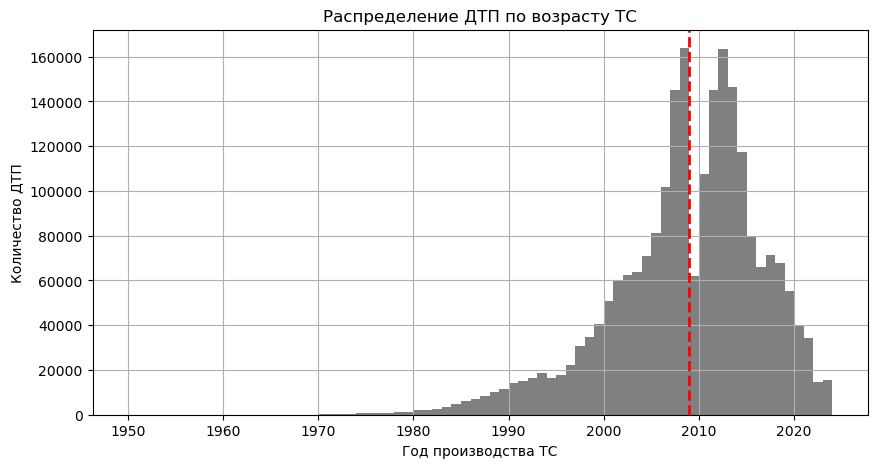

In [25]:
plt.figure(figsize=(10,5))

expanded_df['vehicle_year'].hist(bins=74, range=(1950,2024), color='grey')
plt.axvline(x=2009, color='red', linestyle='--', linewidth=2)
plt.xlabel('Год производства ТС')
plt.ylabel('Количество ДТП')
plt.title('Распределение ДТП по возрасту ТС')
plt.show()

Крайне интересно - в целом, график показывает распределение возраста парка автомобилей, на дорогах больше всего ТС с возрастом 10-20 лет.
Но интересен значительный провал в количестве ДТП, совершенных машинами `2009 года выпуска`. С чем это может быть связано?
- в 2009 году произвели существенно меньше машин, поэтому их меньше участвует в ДТП
- владельцы машин 2009 года выпуска особенно внимательны на дороге и не нарушают правила
- магия числа 2009

Но верный ответ, вероятнее всего - продажи машин в 2009 году. И да, запрос в интернет выдает нам информацию, что:  
            "*...2009 год был исключительно сложным для автомобильной промышленности во всем мире, но особенно сильно это затронуло Россию, где падение рынка в отдельные месяцы по сравнению с предыдущим годом составляло до 60%*"  

https://greenway.icnet.ru/CarSale_2009_3.html


- распределение ДТП по водительскому стажу


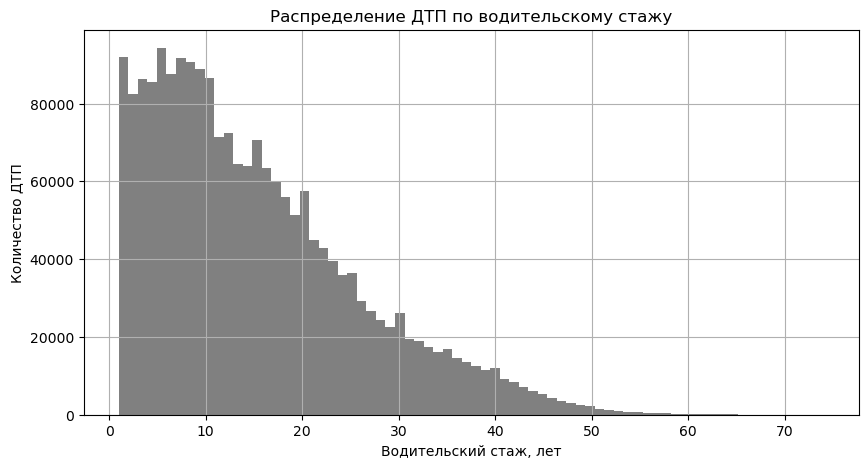

In [26]:
plt.figure(figsize=(10,5))

expanded_df['driver_years_of_driving_experience'].hist(bins=74, color='grey')
# plt.axvline(x=2009, color='red', linestyle='--', linewidth=2)
plt.xlabel('Водительский стаж, лет')
plt.ylabel('Количество ДТП')
plt.title('Распределение ДТП по водительскому стажу')
plt.show()

- кривая распределение показывает плавное снижение количества ДТП после стажа в 10 лет. Видимо, тому есть 2 причины:
    - после 10 лет вождения действительно накапливается знание различных дорожных ситуаций и оттачивается реакция на них, что приводит к снижению числа ДТП. Другими словами - требуется 10 лет стажа, чтобы действительно научиться ездить безопасно.
    - чем больше стаж, тем больше возраст. Чем больше возраст, тем реже люди садятся за руль. Соответственно, меньше ДТП.

Для того, чтобы сделать эту статистику еще точнее, можем посмотреть на взаимосвязь стажа и количества тяжелых ДТП с погибшими.

In [27]:
driver_exp_severity = ( 
    expanded_df.groupby('driver_years_of_driving_experience')
    .agg(
        severity_fatal=('severity', lambda x: np.sum(x == 'С погибшими')),
        total_count=('parent_id','count')
        
        ).reset_index()                        
                       )
driver_exp_severity['fatal_rate'] = driver_exp_severity['severity_fatal'] / driver_exp_severity['total_count'] * 100

display(driver_exp_severity)

,driver_years_of_driving_experience,severity_fatal,total_count,fatal_rate
0,1.00,6713,91923,7.30
1,2.00,5961,82520,7.22
2,3.00,6589,86419,7.62
3,4.00,6709,85476,7.85
4,5.00,7448,94284,7.90
5,6.00,7103,87631,8.11
6,7.00,7668,91780,8.35
7,8.00,7427,90639,8.19
8,9.00,7607,88807,8.57
9,10.00,7531,86564,8.70


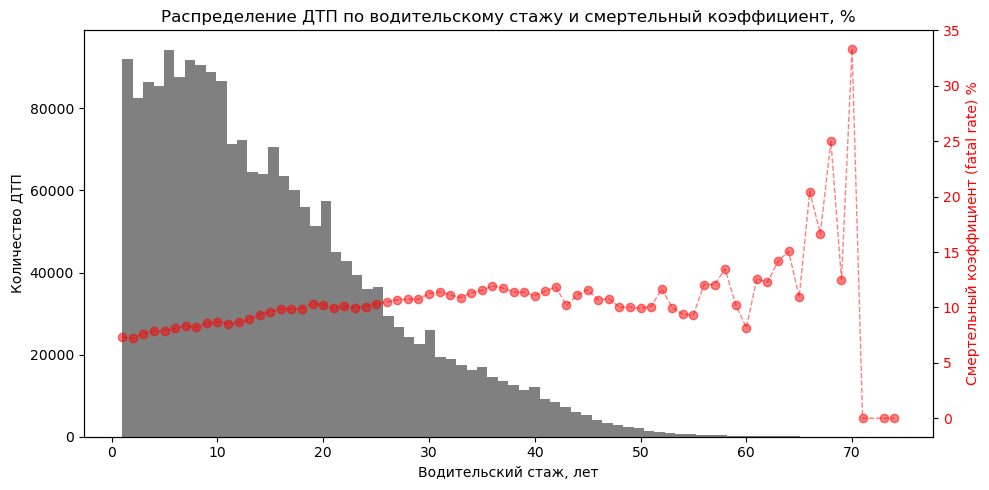

In [28]:
# Построение графиков
fig, ax1 = plt.subplots(figsize=(10, 5))

# Гистограмма для распределения ДТП по стажу водителей
ax1.hist(expanded_df['driver_years_of_driving_experience'], bins=74, color='grey')
ax1.set_xlabel('Водительский стаж, лет')
ax1.set_ylabel('Количество ДТП', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Создание второй оси Y для fatal rate
ax2 = ax1.twinx()
ax2.plot(driver_exp_severity['driver_years_of_driving_experience'], driver_exp_severity['fatal_rate'], 
         color='red', marker='o', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylabel('Смертельный коэффициент (fatal rate) %', color='red')
ax2.tick_params(axis='y', labelcolor='red')


plt.title('Распределение ДТП по водительскому стажу и смертельный коэффициент, %')

# Показать график
plt.tight_layout()
plt.show()

- на графике прослеживается плавный рост смертности в ДТП с ростом водителького стажа со значительными колебаниями после 50 лет - поскольку количество ДТП сильно снижается. Рост может быть вызван снижением физических параметров водителей (зрение, реакция, общее здоровье) - это касается стажа более 30 лет (т.е. возраст водителей около 50+ лет)
- можно проверить **Гипотезу № 1: о том, что статистически количество ДТП со смертельными исходами составляет в среднем 10% от общего количества ДТП**  

**Гипотеза №2: средний водительский стаж для большинства ДТП - 10 лет.**


### Посмотрим на статистику ДТП по годам и месяцам, дням недели и времени

Сгруппируем данные по периодам, с агрегацией по количеству ДТП, пострадавших и погибших.


In [29]:
# Группировка с подсчетом всех метрик + количества по каждому типу severity
all_data_united_summary = (
    all_data_united.groupby(['year', 'month', 'weekday', 'hour', 'parent_region'])
    .agg(
        dtp_count=('id', 'count'),
        total_participants=('participants_count', 'sum'),
        total_injured=('injured_count', 'sum'),
        total_dead=('dead_count', 'sum'),
        severity_light=('severity', lambda x: np.sum(x == 'Легкий')),
        severity_heavy=('severity', lambda x: np.sum(x == 'Тяжёлый')),
        severity_fatal=('severity', lambda x: np.sum(x == 'С погибшими'))
    )
    .reset_index()
)

# Вывод результатов
display(all_data_united_summary.head())

,year,month,weekday,hour,parent_region,dtp_count,total_participants,total_injured,total_dead,severity_light,severity_heavy,severity_fatal
0,2015,1,1,0,Алтайский край,1,3,0,1,0,0,1
1,2015,1,1,0,Архангельская область,1,3,1,1,0,0,1
2,2015,1,1,0,Белгородская область,1,2,2,0,0,1,0
3,2015,1,1,0,Владимирская область,2,6,3,0,0,2,0
4,2015,1,1,0,Воронежская область,1,2,1,0,0,1,0


In [30]:
# Сохраняем DataFrame'ы на диск
all_data_united_summary.to_csv('all_data_united_summary.csv', index=False, encoding='utf-8')

print(all_data_united_summary.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760725 entries, 0 to 760724
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   year                760725 non-null  int32 
 1   month               760725 non-null  int32 
 2   weekday             760725 non-null  int32 
 3   hour                760725 non-null  int32 
 4   parent_region       760725 non-null  object
 5   dtp_count           760725 non-null  int64 
 6   total_participants  760725 non-null  int16 
 7   total_injured       760725 non-null  int8  
 8   total_dead          760725 non-null  int8  
 9   severity_light      760725 non-null  int64 
 10  severity_heavy      760725 non-null  int64 
 11  severity_fatal      760725 non-null  int64 
dtypes: int16(1), int32(4), int64(4), int8(2), object(1)
memory usage: 43.5+ MB
None


Анализ по годам: рост или снижение ДТП с течением времени


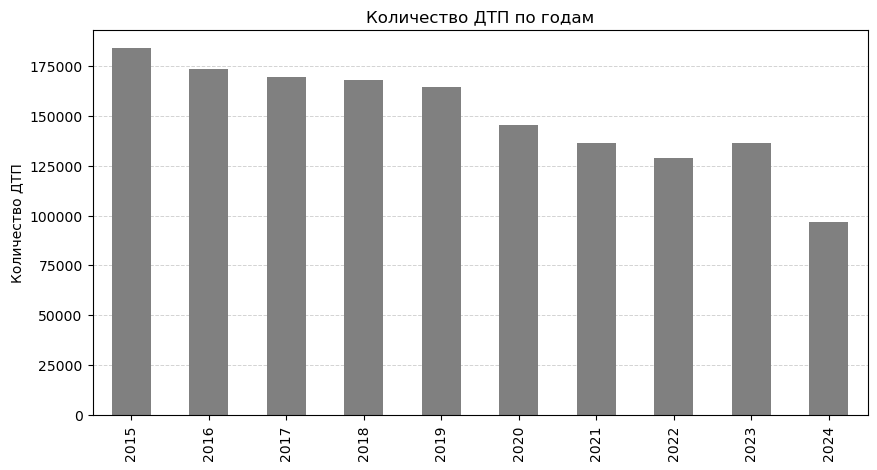

In [31]:
plt.figure(figsize=(10, 5))

# Построение графика
ax = all_data_united_summary.groupby('year')['dtp_count'].sum().plot(
    kind='bar', 
    color='gray', 
    title='Количество ДТП по годам'
)

# Добавление сетки на задний план
ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.7, zorder=0)
ax.set_axisbelow(True)  # Указывает, что элементы осей (например, сетка) должны быть под данными

# Подписи осей
plt.ylabel("Количество ДТП")
plt.xlabel("")

# Показать график
plt.show()


- согласно графику, количество ДТП планомерно снижалось до 2022. С 2023 опять наблюдается рост (данные 2024 до 30.09, поэтому можем провести анализ сопоставимых периодов - с 01.01 по 30.09)

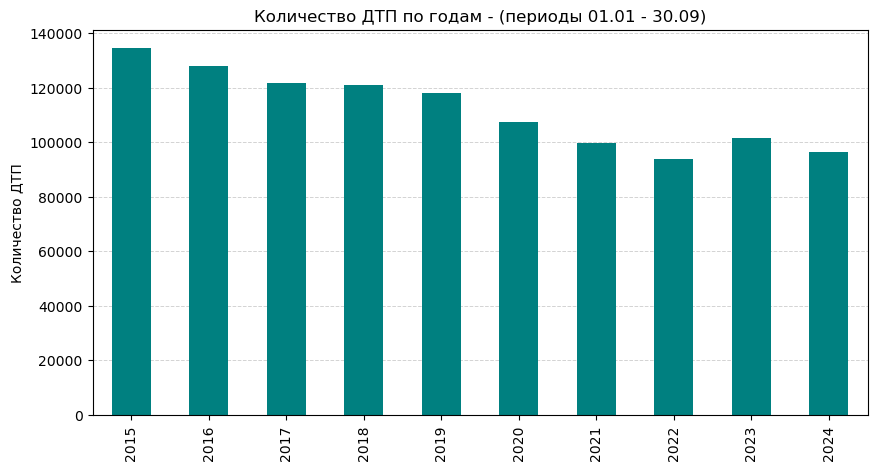

In [32]:
all_data_united_summary_till_sep = all_data_united_summary.query('month <= 9')

plt.figure(figsize=(10,5))

ax = all_data_united_summary_till_sep.groupby('year')['dtp_count'].sum().plot(kind='bar', color = 'teal', title='Количество ДТП по годам - (периоды 01.01 - 30.09)')

# Добавление сетки на задний план
ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.7, zorder=0)
ax.set_axisbelow(True)  # Указывает, что элементы осей (например, сетка) должны быть под данными

plt.ylabel("Количество ДТП")
plt.xlabel("")
plt.show()

- На графике виден рост количества ДТП в 2023, но результат 2024 ниже (но выше 2022).

Интересно выяснить, за счет каких регионов произошел рост количества ДТП в 2023. Для этого выведем данные, сгруппированные по регионам, где есть рост количества ДТП в 2023 году. Отсортируем данные по количеству ДТП 2023 года, посчитаем кумулятивную долю каждого региона от общего количества и оставим только регионы, делающие 80% ДТП.


In [33]:
all_data_summary_regions_2022_2023 = (
    all_data_united_summary.query('year in [2022, 2023]')
    .groupby(['parent_region', 'year'], as_index=False)
    .agg({'dtp_count': 'sum'})  # Агрегируем дубликаты
    .pivot(index='parent_region', columns='year', values='dtp_count')
    .fillna(0)  # Заменяем NaN на 0
)

all_data_summary_regions_2022_2023['diff_perc'] = ((all_data_summary_regions_2022_2023[2023] - all_data_summary_regions_2022_2023[2022])/all_data_summary_regions_2022_2023[2022])*100

# Сортируем данные по значениям за 2023 год в порядке убывания
all_data_summary_regions_2022_2023 = all_data_summary_regions_2022_2023.sort_values(by=2023, ascending=False)

# Считаем общий объем ДТП за 2023 год
total_dtp_2023 = all_data_summary_regions_2022_2023[2023].sum()

# Рассчитываем долю каждого региона
all_data_summary_regions_2022_2023['share'] = all_data_summary_regions_2022_2023[2023] / total_dtp_2023

# Рассчитываем накопительную долю
all_data_summary_regions_2022_2023['cumsum_share'] = all_data_summary_regions_2022_2023['share'].cumsum()

# Фильтруем регионы, которые дают в сумме <= 80% ДТП
top_80_percent_regions = all_data_summary_regions_2022_2023[all_data_summary_regions_2022_2023['cumsum_share'] <= 0.8].reset_index()

# Выводим результаты
display(top_80_percent_regions.sort_values(by=2023, ascending=False))


year,parent_region,2022,2023,diff_perc,share,cumsum_share
0,Москва,7780,8196,5.35,0.06,0.06
1,Краснодарский край,5836,6193,6.12,0.05,0.11
2,Нижегородская область,4410,4814,9.16,0.04,0.14
3,Санкт-Петербург,4280,4210,-1.64,0.03,0.17
4,Московская область,4007,3983,-0.60,0.03,0.20
5,Республика Башкортостан,3597,3750,4.25,0.03,0.23
6,Челябинская область,3549,3735,5.24,0.03,0.26
7,Республика Татарстан (Татарстан),3443,3547,3.02,0.03,0.28
8,Красноярский край,2770,3133,13.10,0.02,0.30
9,Самарская область,2852,3044,6.73,0.02,0.33


- по полученным данным видно, что прирост количества ДТП по крупнейшим регионам (Москва, Краснодарский край и пр.) составляет 5-10%, но общего тренда равномерного увеличения количества ДТП не наблюдается, движение разнонаправленное.
- 80% ДТП от общего их числа в 2023 году произошло в 42 регионах РФ, что составляет почти половину от общего числа регионов (85)


### Для того, чтобы дополнить данные статистики ДТП и иметь возможность делать сравнительные выводы, используем статистику по количеству жителей регионов и количеству автомобилей.

Я скачал с официального сайта Росстатистики данные переписи населения по регионам с 2015 по 2023 год и статистику по зарегистрированному количеству автомобилей на 1000 чел. по регионам.

https://rosstat.gov.ru/


Загрузим эти файлы и объединим с нашими сводными данными по регионам и годам.

In [34]:
%pip install xlrd

try:
    population_df = pd.read_excel('population_by_region.xls')
except Exception as e:
    print('Ошибка чтения файла', e)

try:
    cars_df = pd.read_excel('number_of_cars_per_1000_by_region.xls')
except Exception as e:
    print('Ошибка чтения файла', e)

display(population_df.head())
display(cars_df.head())


# Группировка с подсчетом всех метрик + количества по каждому типу severity
all_data_united_regions_population_cars = (
    all_data_united.groupby(['parent_region', 'year'])
    .agg(
        dtp_count=('id', 'count'),
        total_participants=('participants_count', 'sum'),
        total_injured=('injured_count', 'sum'),
        total_dead=('dead_count', 'sum')
    ).reset_index()
)

display(all_data_united_regions_population_cars.head())

Note: you may need to restart the kernel to use updated packages.


,Region,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Российская Федерация,146963159,147381167,147688545,147818888,147899994,147707517,147217903,146713743,146299106
1,Белгородская область,1551105,1553965,1554224,1551910,1551920,1549193,1540947,1525496,1507593
2,Брянская область,1226690,1220548,1213075,1202671,1193180,1184133,1171845,1158570,1147454
3,Владимирская область,1408811,1402656,1394996,1384818,1376582,1366384,1350639,1333872,1317726
4,Воронежская область,2338257,2341760,2343280,2340861,2337457,2327739,2310877,2293949,2279349


,region,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Российская Федерация,287.51,292.43,303.06,306.93,312.87,318.24,324.46,326.86,332.08
1,Белгородская область,308.26,316.79,328.12,322.23,320.69,327.04,332.09,336.29,340.43
2,Брянская область,193.04,199.72,208.92,202.84,202.97,207.25,212.46,213.61,216.35
3,Владимирская область,286.64,272.39,283.65,293.26,300.29,306.07,310.06,315.61,316.77
4,Воронежская область,325.26,327.08,335.07,345.12,353.57,358.09,361.52,362.43,366.25


,parent_region,year,dtp_count,total_participants,total_injured,total_dead
0,Алтайский край,2015,3493,8394,4449,313
1,Алтайский край,2016,3206,7662,4061,257
2,Алтайский край,2017,3107,7454,3949,297
3,Алтайский край,2018,2901,7074,3716,237
4,Алтайский край,2019,2796,6763,3584,252


In [35]:
# Преобразование численности населения в длинный формат
population_long = population_df.melt(
    id_vars=['Region'], var_name='year', value_name='population'
)
population_long['year'] = population_long['year'].astype(int)

display(population_long.head())

# Преобразование количества машин в длинный формат
cars_long = cars_df.melt(
    id_vars=['region'], var_name='year', value_name='cars_per_1000'
)
cars_long['year'] = cars_long['year'].astype(int)

display(cars_long.head())

,Region,year,population
0,Российская Федерация,2015,146963159
1,Белгородская область,2015,1551105
2,Брянская область,2015,1226690
3,Владимирская область,2015,1408811
4,Воронежская область,2015,2338257


,region,year,cars_per_1000
0,Российская Федерация,2015,287.51
1,Белгородская область,2015,308.26
2,Брянская область,2015,193.04
3,Владимирская область,2015,286.64
4,Воронежская область,2015,325.26


In [36]:
# Объединение с численностью населения
merged_data = pd.merge(
    all_data_united_regions_population_cars,
    population_long,
    left_on=['parent_region', 'year'],
    right_on=['Region', 'year'],
    how='left'
)

# Объединение с количеством машин
merged_data = pd.merge(
    merged_data,
    cars_long,
    left_on=['parent_region', 'year'],
    right_on=['region', 'year'],
    how='left'
)

# Удаление лишних колонок (Region, region после объединения)
merged_data.drop(columns=['Region', 'region'], inplace=True)

# Проверка результата
display(merged_data.head())

,parent_region,year,dtp_count,total_participants,total_injured,total_dead,population,cars_per_1000
0,Алтайский край,2015,3493,8394,4449,313,"2,334,206.00",282.35
1,Алтайский край,2016,3206,7662,4061,257,"2,314,315.00",284.49
2,Алтайский край,2017,3107,7454,3949,297,"2,290,644.00",300.80
3,Алтайский край,2018,2901,7074,3716,237,"2,263,889.00",320.75
4,Алтайский край,2019,2796,6763,3584,252,"2,237,107.00",344.34


- теперь мы можем рассчитать количество автомобилей на регион и высчитать процент ДТП от количества машин 

In [37]:
merged_data['cars_estimate'] = merged_data['population']/1000 * merged_data['cars_per_1000']
merged_data['dtp_ratio'] = round(merged_data['dtp_count'] / merged_data['cars_estimate'] * 100, 2)

display(merged_data.query('year==2023').sort_values(by='dtp_ratio', ascending=False))



,parent_region,year,dtp_count,total_participants,total_injured,total_dead,population,cars_per_1000,cars_estimate,dtp_ratio
588,Республика Тыва,2023,508,1464,726,112,"337,408.00",175.04,"59,059.19",0.86
448,Республика Алтай,2023,362,924,491,36,"210,766.00",267.34,"56,345.27",0.64
498,Республика Калмыкия,2023,545,1445,785,124,"265,627.00",339.28,"90,121.21",0.60
368,Омская область,2023,2778,6978,3656,188,"1,825,078.00",277.01,"505,560.90",0.55
748,Тюменская область,2023,3009,7198,3818,200,"1,611,974.00",358.50,"577,893.42",0.52
218,Костромская область,2023,958,2438,1190,77,"569,082.00",334.64,"190,438.35",0.50
108,Еврейская автономная область,2023,220,496,294,22,"146,629.00",313.62,"45,986.37",0.48
18,Амурская область,2023,1175,2966,1564,112,"753,139.00",322.32,"242,752.01",0.48
468,Республика Бурятия,2023,1238,3119,1671,116,"973,275.00",274.79,"267,446.79",0.46
208,Кировская область,2023,1611,3798,2026,151,"1,134,023.00",314.98,"357,189.62",0.45


Идея для **Гипотезы №3: возраст авто и смертность в ДТП - есть прямая корреляция.**


### Посмотрим на графике на показатель количества ДТП на количество машин по регионам и его изменение по годам

Анализ ДТП по месяцам: есть ли сезонность?

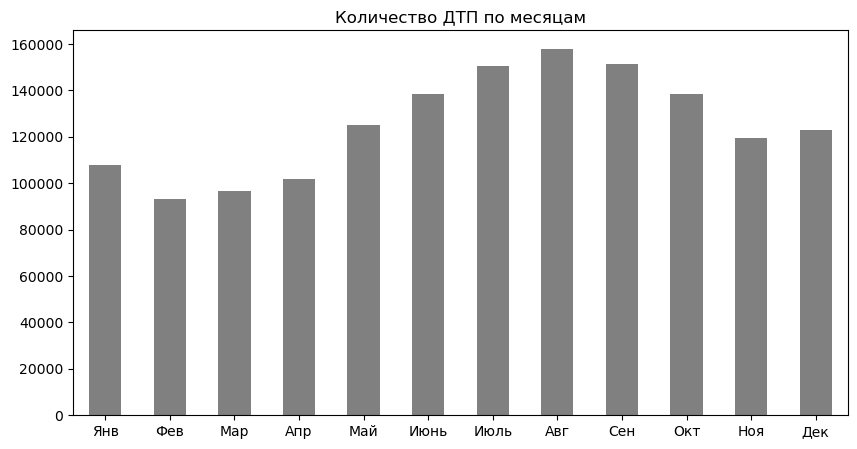

In [38]:
plt.figure(figsize=(10, 5))
months = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

all_data_united_summary.groupby('month')['dtp_count'].sum().plot(kind='bar', color='grey')

plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], months, rotation=0)
plt.title('Количество ДТП по месяцам')

plt.show()

- вот любопытно: казалось бы, ДТП должно быть больше, когда сложные погодные условия - снег, дожди, лед на дороге, т.е. зимой. Но лидирует лето и начало осенни - `июнь-октябрь`. Видимо, имеет значение количество поездок - зимой многие предпочитают лишний раз не пользоваться автомобилем - сложно ездить, парковать и пр.

Какие дни недели наиболее опасны на дороге?

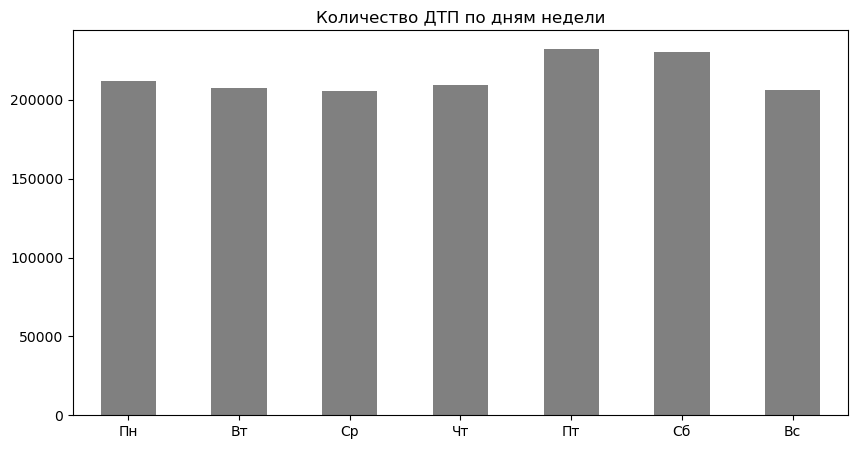

In [39]:
plt.figure(figsize=(10, 5))

# Названия дней недели
weekdays = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

# Группировка по дням недели и построение графика
all_data_united_summary.groupby('weekday')['dtp_count'].sum().reindex(range(1, 8)).plot(kind='bar', color='grey')

# Оформление графика
plt.xlabel('')
plt.ylabel('')
plt.xticks(range(7), weekdays, rotation=0)
plt.title('Количество ДТП по дням недели')

plt.show()

- тут очевидно: пятница и суббота опаснее остальных дней

Дни недели и часы: пик аварийности в определённое время.

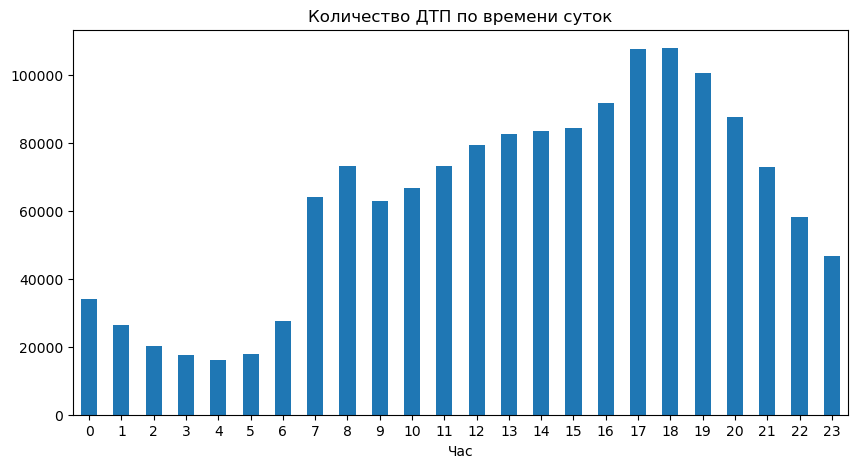

In [40]:


plt.figure(figsize=(10, 5))

all_data_united_summary.groupby('hour')['dtp_count'].sum().plot(kind='bar', title='ДТП по часам')

plt.xlabel('Час')
plt.ylabel('')
plt.xticks(rotation=0)
plt.title('Количество ДТП по времени суток')

plt.show()

- тут все более ожидаемо: ночью (0 - 6 часов) мало машин, все спят, мало ДТП. Начиная с 7 утра, когда люди едут на работу, количество ДТП растет, до 8 утра. Дальше начинается рабочий день и плавный рост количества ДТП, с пиком, приходящимся на 17-19 часов, время, когда люди едут с работы - пробки, плотное движение, большое количество незначительных ДТП, попадающих в статистику.

Для того, чтобы проверить это предположение - сделем аналогичные графики, но для типов ДТП по ущербу.


In [41]:
grouped_by_hour = ( 
    all_data_united_summary.groupby('hour')
    .agg(
        dtp_total = ('dtp_count', 'sum'),
        severity_light = ('severity_light', 'sum'),
        severity_heavy = ('severity_heavy', 'sum'),
        severity_fatal = ('severity_fatal', 'sum'),
    ).reset_index()     
                   )
display(grouped_by_hour)

,hour,dtp_total,severity_light,severity_heavy,severity_fatal
0,0,33940,15770,12644,5526
1,1,26435,12069,9874,4492
2,2,20321,8948,7728,3645
3,3,17481,7504,6684,3293
4,4,16205,6862,6246,3097
5,5,17812,7707,6828,3277
6,6,27714,13614,9919,4181
7,7,64033,37192,21408,5433
8,8,73032,45195,22954,4883
9,9,62976,38658,19790,4528


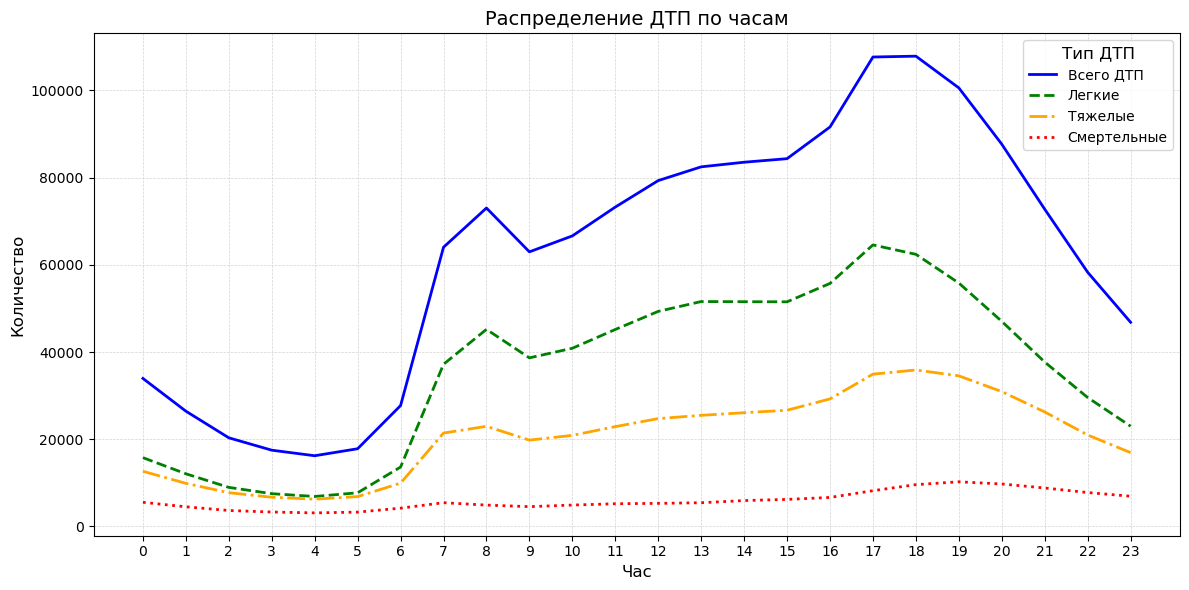

In [42]:
# Построение графика
plt.figure(figsize=(12, 6))

plt.plot(grouped_by_hour['hour'], grouped_by_hour['dtp_total'], label='Всего ДТП', color='blue', linewidth=2)
plt.plot(grouped_by_hour['hour'], grouped_by_hour['severity_light'], label='Легкие', color='green', linestyle='--', linewidth=2)
plt.plot(grouped_by_hour['hour'], grouped_by_hour['severity_heavy'], label='Тяжелые', color='orange', linestyle='-.', linewidth=2)
plt.plot(grouped_by_hour['hour'], grouped_by_hour['severity_fatal'], label='Смертельные', color='red', linestyle=':', linewidth=2)

# Настройка осей
plt.xticks(grouped_by_hour['hour'])
plt.xlabel('Час', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.title('Распределение ДТП по часам', fontsize=14)

# Легенда
plt.legend(title='Тип ДТП', fontsize=10, title_fontsize=12)

# Сетка
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)

# Отображение
plt.tight_layout()
plt.show()

- как видно из формы графика, количество "легких" ДТП по времени повторяет общий тренд, а вот у смертельных ДТП другая картина: пик приходится на период 18-21 час, в отличие от "легких". И в целом, распределение по времени более равномерное. 

**Топ-10 регионов по количеству ДТП**

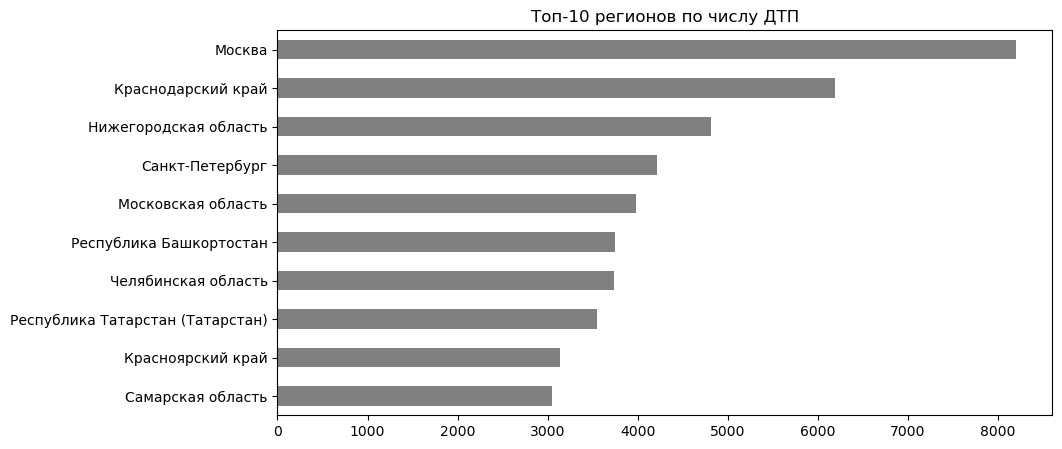

In [43]:
plt.figure(figsize=(10, 5))

( 
    all_data_united_summary.query('year==2023').groupby('parent_region')['dtp_count']
    .sum()
    .nlargest(10)
    .sort_values(ascending=True)
    .plot(kind='barh', color='grey' ))

plt.ylabel("")
plt.xlabel('')
plt.title('Топ-10 регионов по числу ДТП')

plt.show()

- тут вроде все понятно: больше население региона = больше машин = больше ДТП

А если дополнить этот график значением отношения количества ДТП к количеству автомобилей в регионе?

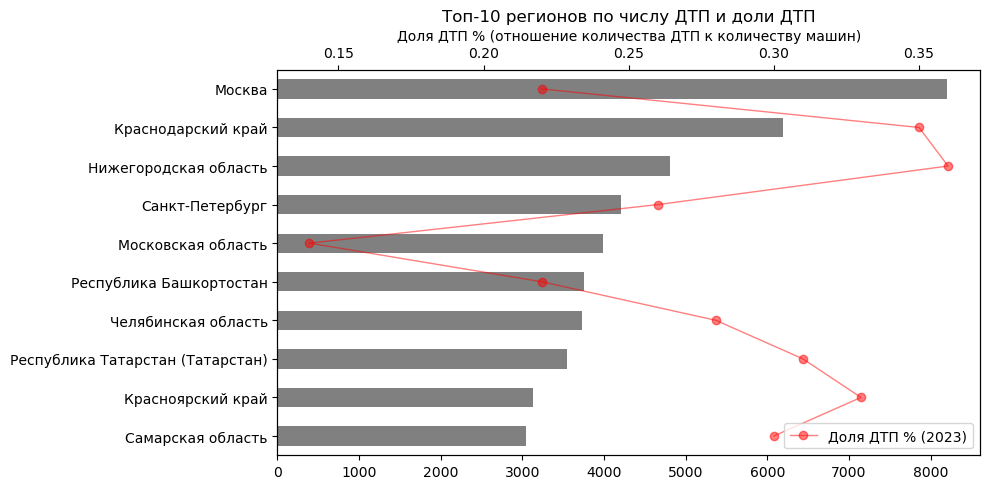

In [44]:
# Данные для первого графика
top_regions = (
    all_data_united_summary.query('year==2023').groupby('parent_region')['dtp_count']
    .sum()
    .nlargest(10)
    .sort_values(ascending=True)
)

# Получаем значения dtp_ratio из merged_data для соответствующих регионов за 2023 год
dtp_ratios = merged_data.query('year == 2023').set_index('parent_region').loc[top_regions.index, 'dtp_ratio']

# Создаем фигуру и первую ось
fig, ax1 = plt.subplots(figsize=(10, 5))

# График для первого набора данных (dtp_count)
top_regions.plot(kind='barh', color='grey', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Топ-10 регионов по числу ДТП и доли ДТП')

# Создаем вторую ось
ax2 = ax1.twiny()

# График для второго набора данных (dtp_ratio)
ax2.plot(dtp_ratios.values, top_regions.index, 'o-', color='red', linewidth=1, alpha=0.5, label='Доля ДТП % (2023)')
ax2.set_xlabel('Доля ДТП % (отношение количества ДТП к количеству машин)')

# Легенда и сетка
ax2.legend(loc='lower right')


# Отображаем график
plt.tight_layout()
plt.show()

- как становится очевидно из графика, абсолютные показатели количества ДТП не отражают реальную ситуацию `аварийности` - в сравнимых регионах по абсолютному количеству ДТП может быть существенные различия в доле количества ДТП на количество машин. Так, например, количество ДТП в Московской области сравнимо с Санкт-Петербургом, но доля ДТП в СПб выше в 2 раза - 0.26% против 0.13% в Московской области.

Давайте посмотрим на графике распределение значений доли ДТП за 2023 год (мы не можем взять данные за 2024, поскольку еще нет статистики по населению и числу машин)

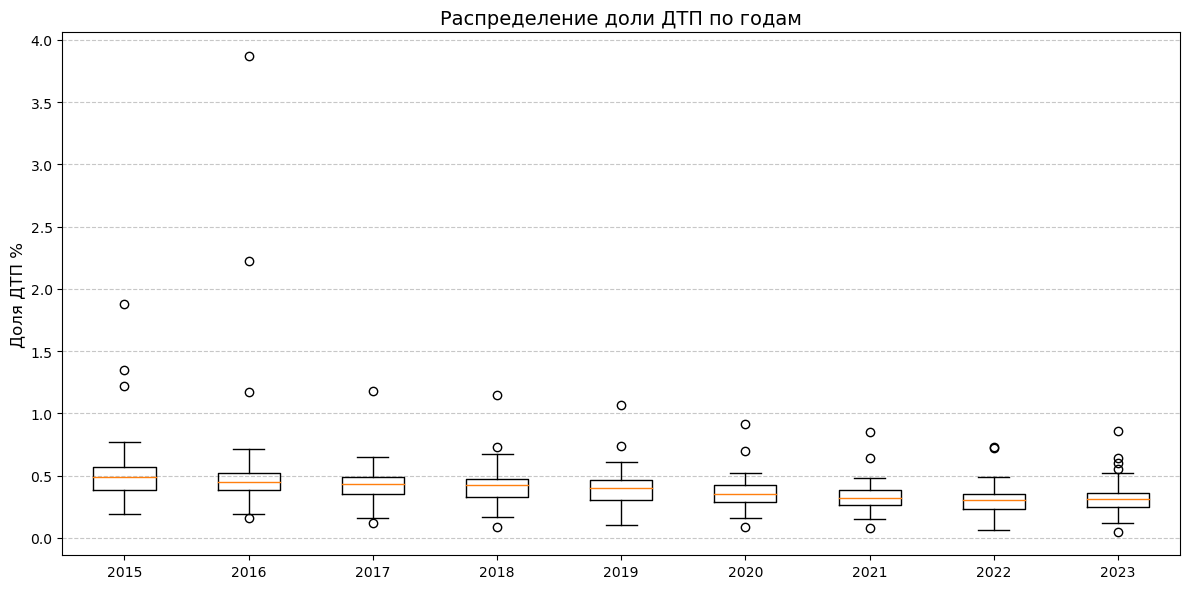

In [45]:
plt.figure(figsize=(12, 6))

# Фильтруем данные и исключаем 2024 год
data = merged_data.query('year != 2024')

# Создаём boxplot для каждого года
years = sorted(data['year'].unique())  # Список годов
data_to_plot = [data.loc[data['year'] == year, 'dtp_ratio'] for year in years]

plt.boxplot(x=data_to_plot)

# Подписи осей
plt.xticks(ticks=range(1, len(years) + 1), labels=years, fontsize=10)
plt.ylabel('Доля ДТП %', fontsize=12)
plt.xlabel('')
plt.title('Распределение доли ДТП по годам', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Лёгкая сетка для оси Y
plt.tight_layout()
plt.show()


- на графике распределения величин доли ДТП прослеживается несколько моментов:
1. с 2015 до 2022 снижалась `медиана` доли ДТП - с 0.5% до 0.31%, т.е. можно сказать - в **бОльшем количестве регионов снижалась аварийность**. 
2. В 2023 показатель доли ДТП несколько растет. Как и общее количество, которое мы смотрели на графиках выше.
3. С 2015 по 2022 снижался разброс доли ДТП по разным регионам: достаточно посмотреть на межкварильный диапазон и выбросы в 2015 и 2022. Другими словами, стало меньше различие между регионами по количеству ДТП на количество машин в регионе.

**Сравнение смертности в ДТП по регионам**

- смертность в ДТП - наш ключевой показатель, давайте внимательно посмотрим на динамику по регионам.

Рассчитаем смертность как количество погибших / количество ДТП по каждому региону по годам и выведем все на тепловую карту, отсортировав от большего к меньшему по значениям 2024 года

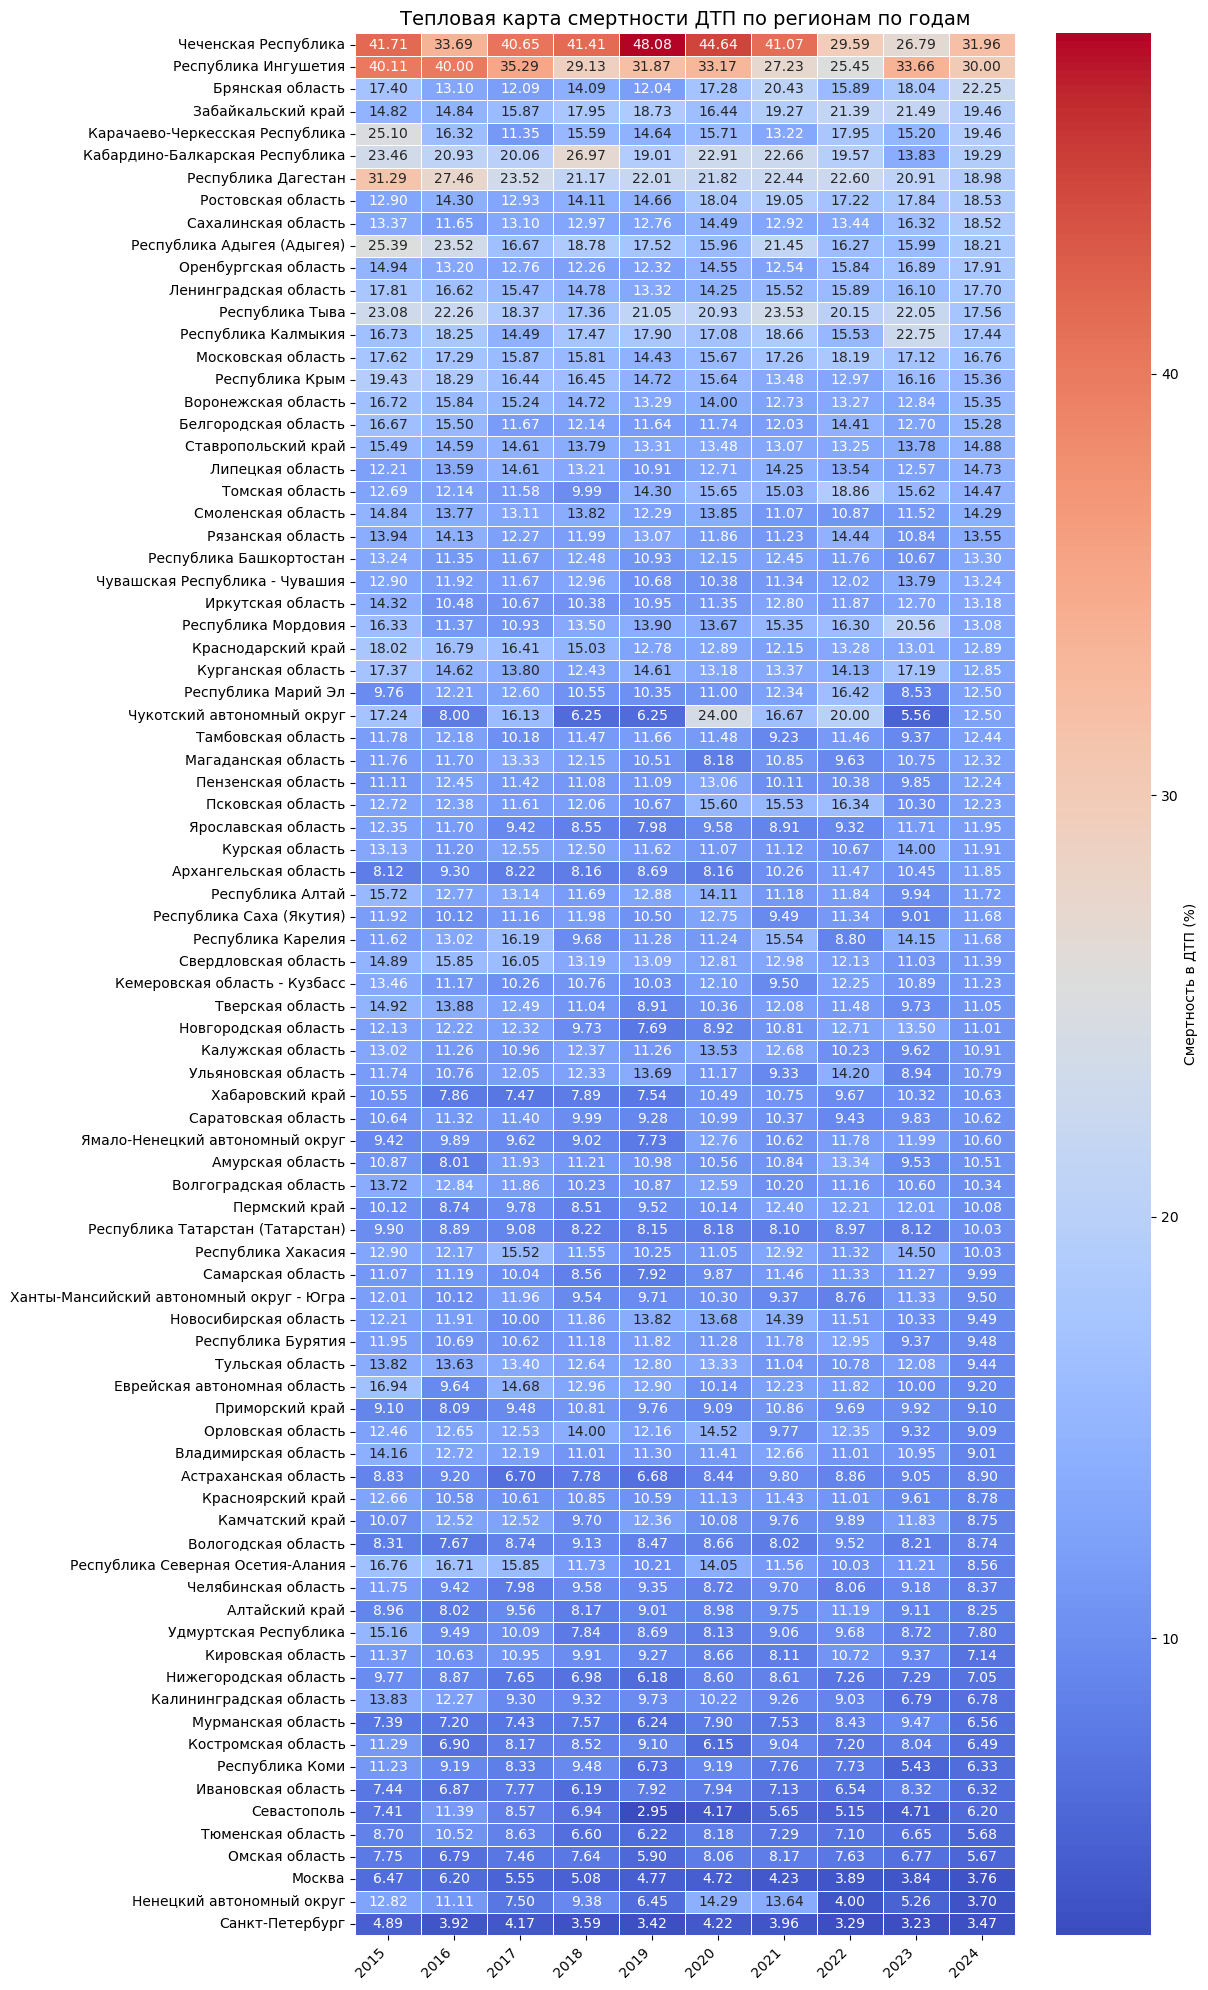

In [46]:
heatmap_data = (
    all_data_united_summary
    .groupby(['parent_region', 'year'], as_index=False)
    .agg(dtp_count=('dtp_count', 'sum'), casualties=('total_dead', 'sum'))
)

# Рассчитываем fatality_rate
heatmap_data['fatality_rate'] = round(heatmap_data['casualties'] / heatmap_data['dtp_count']*100, 2)

# Преобразуем данные в формат pivot (регион x год)
heatmap_pivot = heatmap_data.pivot(index='parent_region', columns='year', values='fatality_rate')

# Сортируем регионы по значениям 2024 года
heatmap_pivot = heatmap_pivot.sort_values(by=2024, ascending=False)

# Построение тепловой карты
plt.figure(figsize=(12, 20))
sns.heatmap(
    heatmap_pivot,
    cmap='coolwarm',
    annot=True,  # Подписи значений
    fmt=".2f",  # Формат чисел
    linewidths=0.5,  # Линии между ячейками
    cbar_kws={'label': 'Смертность в ДТП (%)'},  # Подпись к цветовой шкале
)

# Настройка графика
plt.title('Тепловая карта смертности ДТП по регионам по годам', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- какие выводы очевидны из графика смертности:
1. Исторические лидеры по смертности в ДТП - южные регионы (Чечня, Ингушетия, Дагестан, Кабардино-Балкария, Адыгея). Но не все - к примеру, Осетия имеет сильно лучшую статистику, и она имеет динамику на снижение.
2. Санкт-Петербург имеет наименьшие показатели смертности, почти в 10 раз ниже, чем в Чечне, лучше, чем даже у Москвы. Но если взглянуть на Ленинградскую область, центром которой он является, выяснится, что там смертность выше в 5 раз.

Мое мнение основных причин таких различий:
- крупные города имеют бюджеты и более `совершенную дорожную систему`: современные качественные дороги, светофоры, знаки, освещение, пешеходные переходы. Область же имеет меньше денег на это, что негативно влияет на качество движения. Например, большая часть пешеходных переходов в СПб оборудована светофорами и подсвечена ночью, а в Ленинградской области таких переходов гораздо меньше. Безопасность движения - она зависит как от водителей и пешеходов, так и от окружающей обстановки на дороге.  

- `скорость`. Сложно себе представить дорожное движение без ДТП. Но смертность ДТП зависит в первую очередь от скорости, будь то столкновение машин или столкновение с пешеходом. Во-первых, при меньшей скорости увеличивается время реакции водителя и шанс в торможении существенно замедлить скорость до столкновения. Во-вторых, системы активной и пассивной безопасности в машинах рассчитаны на столкновение при скоростях до 60 км./ ч. Суммарная скорость, т.е. лобовое столкновение 2 машин, едущих со скоростью 40 км. каждая. Свыше 60 км. вероятность выживания стремительно снижается.   

Теперь посмотрим на смертность - специфика южных регионов в их пренебрежительном отношении к ПДД и соблюдению скоростного режима. Проще говоря - они любят "погонять". Отсюда и высокая смертность.

**Гипотеза №4 - превышение скорости является одной из главных причин смертности и количества ДТП в Чеченской республике в 2024 году.**    
Для ее проверки мы возьмем данные смертельных ДТП в Чечне за 2024 год и посмотрим, в каком % из них превышение скорости заявлено, как нарушение и сравним с аналогичным показателем в СПб. 

**Анализ по водителям:**

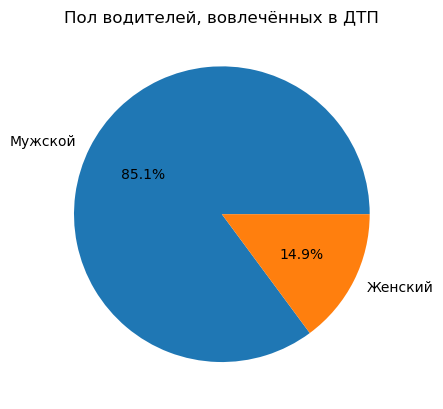

In [47]:
expanded_df['driver_gender'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',  # Добавляет проценты с одним десятичным знаком
    title='Пол водителей, вовлечённых в ДТП'
)
plt.xlabel('')
plt.ylabel('')
plt.show()


- эти данные абсолютные и не говорят нам о том, что мужчины совершают больше ДТП, потому, что водителей-мужчин тоже больше (возможно), статистикой по % водителей по полу мы не располагаем. Но как некий маркер можно проверить **Гипотезу № 5 о том, что мужчины совершают больше ДТП со смертельным исходом, чем женщины.**

**Зависимость количества ДТП и смертности от категории ТС**

Смертность рассчитываем как отношение количества погибших к количеству ДТП для каждой категории ТС.

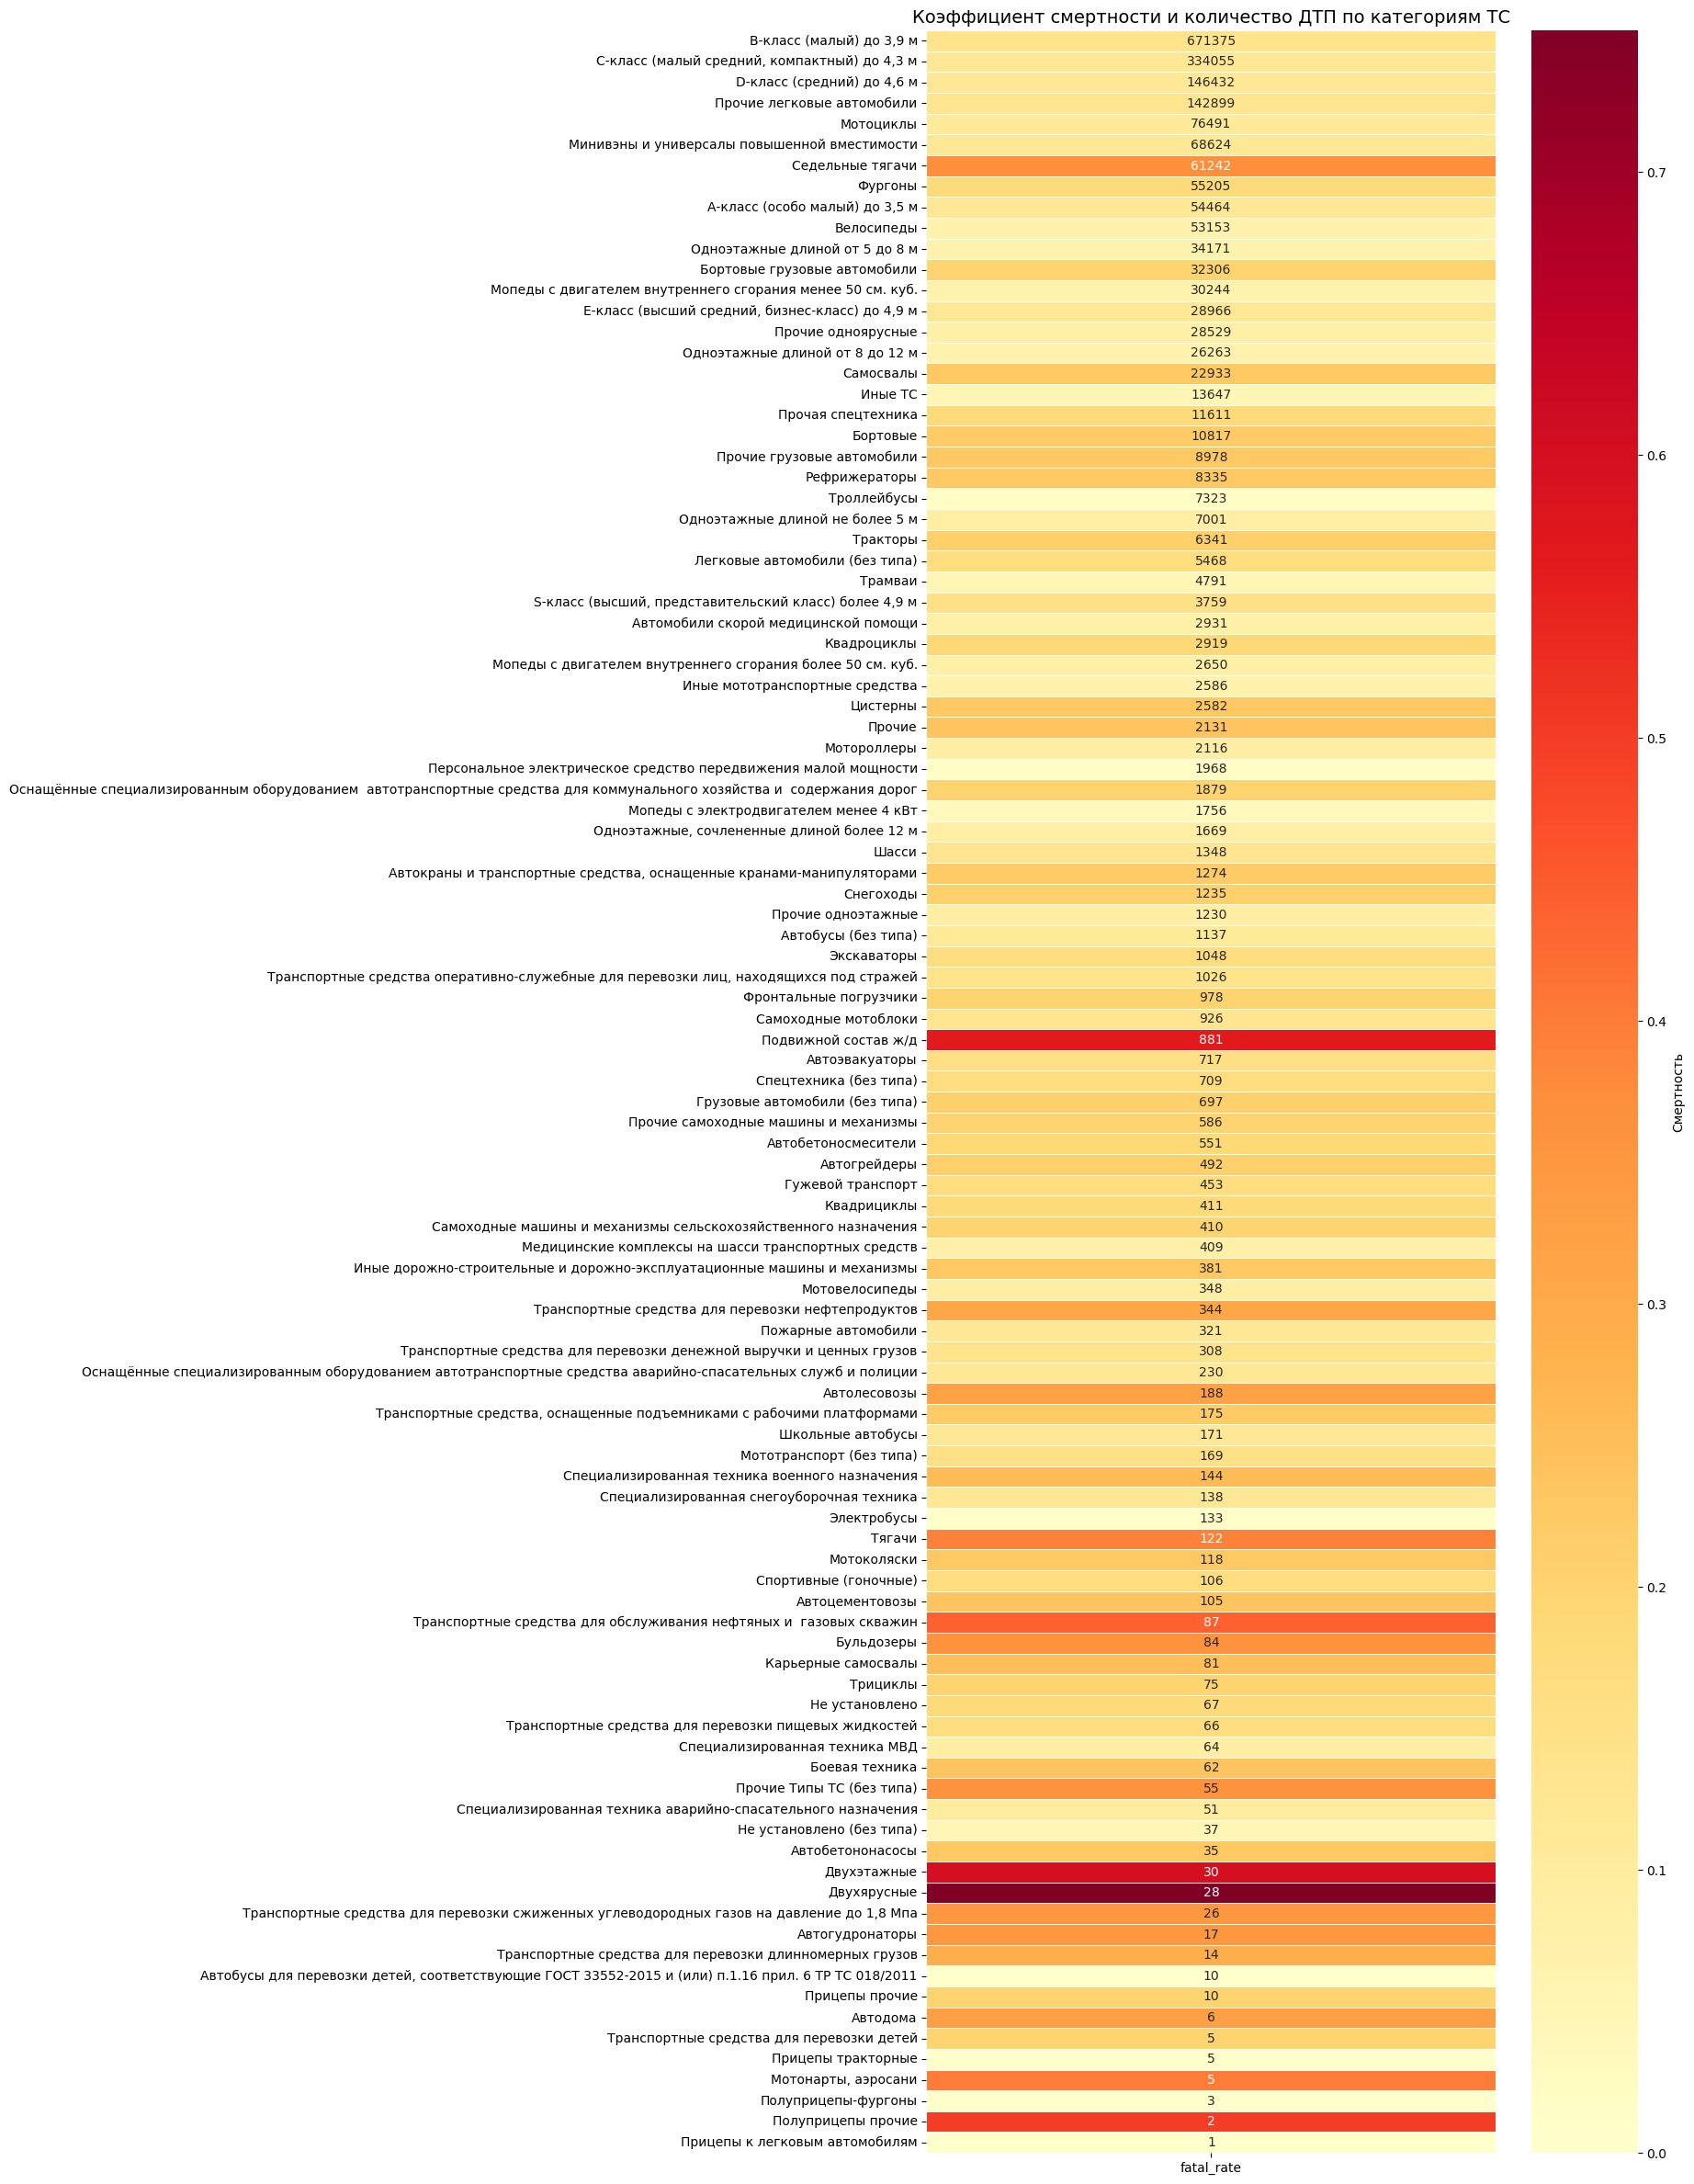

In [48]:
# отбираем данные о ДТП без участия пешеходов (role = NaN)
category_dtp = expanded_df.query('role.isna()').groupby('category').agg( 
    dtp_count = ('parent_id', 'nunique'),
    fatal = ('dead_count','sum')
).reset_index()

category_dtp['fatal_rate'] = round(category_dtp['fatal'] / category_dtp['dtp_count'], 2)

# Добавляем сортировку по количеству ДТП
category_dtp = category_dtp.sort_values('dtp_count', ascending=False)

# Подготовка данных для тепловой карты
heatmap_data = category_dtp.set_index('category')[['fatal_rate', 'dtp_count']]

# Построение тепловой карты
plt.figure(figsize=(10, 30))
sns.heatmap(
    heatmap_data[['fatal_rate']],  # Данные для цветовой шкалы
    annot=heatmap_data[['dtp_count']].values,  # Преобразование в массив для совпадения формы
    fmt=".0f",                     # Формат отображения для количества ДТП
    cmap="YlOrRd",                 # Цветовая схема
    cbar_kws={'label': 'Смертность'},  # Метка для цветовой шкалы
    linewidths=0.5,                # Линии между ячейками
)

# Настройки графика
plt.title('Коэффициент смертности и количество ДТП по категориям ТС', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.show()

- тепловая карта говорит нам о том, что:
1. наибольшее количество ДТП совершаются с участием категорий легковых автомобилей В, С, D-классов и мотоциклов. Это абсолютные значения - этих ТС просто больше всего на дорогах.
2. А вот смертность - это относительная величина. И ее цвета на графике говорят однозначно о том, что смертность наибольшая в ДТП с участием всевозможных грузовиков и спецтехники.

### Итоги статистического анализа данных

Нами проведен анализ распределения количественных критериев и признаков, построены графики зависимостей показателей. Ниже основные наблюдения:
- **9.45%** совершенных ДТП  - с участием детей до 16 лет, **0.84%** ДТП  - с участием пешеходов
- **63.25%** ДТП совершаются в светлое время суток, что отражает режим использование автомобилей: в основном, они используются днем, ночью транспортный поток гораздо меньше, **21.82%** ДТП совершено вечером с освещением - в черте населенного пункта, **11.19%** - без освещения и вне населенного пункта
- **60%** ДТП совершаются в ясную погоду и 31% в пасмурную. В дождь, снег, туман, гололед ДТП существенно меньше - но это опять же связано с абсолютными значениями: дождь и снег статистически идут реже, чем стоит ясная погода
- по типам ДТП лидирует столкновение (**42.69%**). Неожиданно много наездов на пешеходов - **28.36%** и опрокидываний - **6%**
- **57%** ДТП имеют легкую тяжесть, **33.3%** тяжелые и **9.52%** - с погибшими
- возраст участвующих в ДТП машин: больше всего их в пределах **10-20 лет,** любопытный провал с машинами 2009 года выпуска - их в 2 раза меньше
- Наблюдается плавное снижение количества ДТП после водительского стажа в 10 лет
- Количество ДТП планомерно снижалось до 2022. В 2023 опять наблюдается рост, данные 2024 года (до сентября) говорят о снижении
- Прирост количества ДТП в 2023 году по крупнейшим регионам (Москва, Краснодарский край и пр.) составляет 5-10%, но общего тренда равномерного увеличения количества ДТП не наблюдается, движение разнонаправленное
- 80% ДТП от общего их числа в 2023 году произошло в 42 регионах РФ, что составляет почти половину от общего числа регионов (85)
- Сезонность: лето и начало осенни - (июнь-октябрь) лидируют по количеству ДТП
- пятница и суббота опаснее остальных дней, судя по большему количеству ДТП
- По времени суток: тут все более ожидаемо: начиная с 7 утра количество ДТП растет, до 8 утра. Дальше начинается рабочий день и плавный рост количества ДТП, с пиком, приходящимся на 17-19 часов
- Больше всего смертельных ДТП приходятся на период 18-21 час
- В период 2015 - 2022 в бОльшем количестве регионов снижалась аварийность (медиана доли ДТП от количества автомобилей), в 2023 произошел небольшой рост
- Исторические лидеры по смертности в ДТП - южные регионы (Чечня, Ингушетия, Дагестан, Кабардино-Балкария, Адыгея). Но не все - к примеру, Осетия имеет сильно лучшую статистику, и она имеет динамику на снижение.
- Санкт-Петербург имеет наименьшие показатели смертности, почти в 10 раз ниже, чем в Чечне, лучше, чем даже у Москвы. Но если взглянуть на Ленинградскую область, центром которой он является, выяснится, что там смертность выше в 5 раз. Предположительно главные причины - несоблюдение скоростного режима и более низкое качество дорожной системы
- Наибольшее количество ДТП совершаются с участием категорий легковых автомобилей В, С, D-классов и мотоциклов. Это абсолютные значения - этих ТС просто больше всего на дорогах, а смертность наибольшая в ДТП с участием всевозможных грузовиков и спецтехники.



## Формулировка гипотез, выбор методов проверки и сама проверка, выводы

В процессе статистического анализа данных нами сформулировано несколько гипотез, которые мы проверим:

1. Количество ДТП со смертельными исходами составляет в среднем 10% от общего количества ДТП
2. Средний водительский стаж для большинства ДТП - 10 лет
3. Возраст авто и смертность в ДТП - есть прямая корреляция (чем выше возраст авто тем больше ДТП со смертельным исходом)
4. Превышение скорости является одной из главных причин смертности и количества ДТП в Чеченской республике   
5. Мужчины совершают больше ДТП со смертельным исходом, чем женщины


### Гипотеза №1: Количество ДТП со смертельными исходами составляет в среднем 10% от общего количества ДТП

Для проверки гипотезы можно использовать z-тест для доли, чтобы определить, является ли доля ДТП со смертельными исходами статистически равной 10%.

Нулевая гипотеза (H0): Доля ДТП со смертельными исходами равна 10% 
Альтернативная гипотеза (H1): Доля ДТП со смертельными исходами отличается от 10% 

In [49]:
# Общее количество ДТП
total_dtp = all_data_united['id'].nunique()

# Количество ДТП со смертельными исходами
fatal_dtp = all_data_united.query('dead_count >= 1')['id'].nunique()

# Наблюдаемая доля
observed_proportion = fatal_dtp / total_dtp
print(f"Общая доля ДТП со смертельными исходами: {observed_proportion:.2%}")

Общая доля ДТП со смертельными исходами: 9.52%


In [50]:
from statsmodels.stats.proportion import proportions_ztest

# Наблюдаемое количество успехов и общее количество испытаний
successes = fatal_dtp
n = total_dtp

# Гипотетическая доля
hypothesized_proportion = 0.1

# Z-тест
z_stat, p_value = proportions_ztest(count=successes, nobs=n, value=hypothesized_proportion)

print(f"Z-статистика: {z_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: доля ДТП со смертельными исходами значительно отличается от 10%.")
else:
    print("Не удалось отвергнуть нулевую гипотезу: доля ДТП со смертельными исходами не отличается от 10%.")

Z-статистика: -19.9268
P-значение: 0.0000
Отвергаем нулевую гипотезу: доля ДТП со смертельными исходами значительно отличается от 10%.


Вывод: гипотезу о равенстве 10% среднего количества ДТП со смертельным исходом мы можем отвергнуть. Фактическая доля значительно меньше 10%, о чем говорит отрицательное значение Z-статистики


### Гипотеза №2: Средний водительский стаж для большинства ДТП - 10 лет

 Гипотеза H0: Средний водительский стаж для большинства ДТП составляет 10 лет  
​
 Гипотеза H1: Средний водительский стаж для большинства ДТП отличается от 10 лет


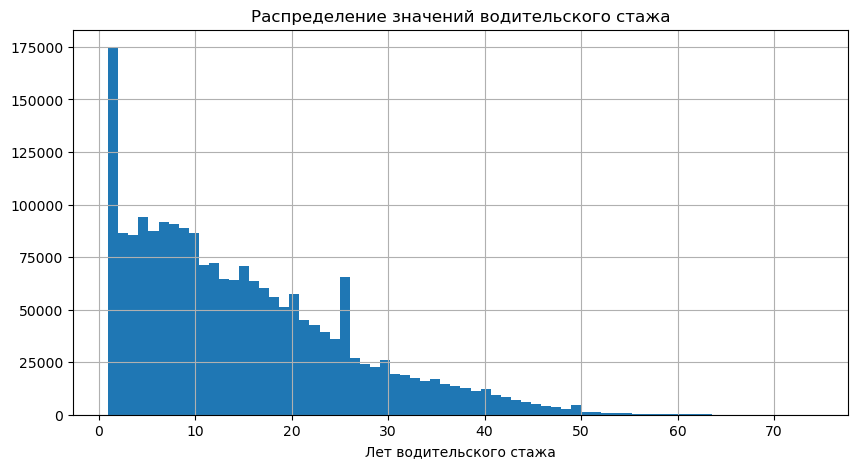

Средний водительский стаж: 12.00
T-статистика: 647.0962
P-значение: 0.0000
Отвергаем нулевую гипотезу: средний стаж отличается от 10 лет.


In [51]:
# В колонке с водительским стажем есть пропуски (NaN), удалим строки с пропусками перед проведением t-test одновыборочного

from scipy.stats import ttest_1samp

# Очистка данных
valid_data = expanded_df[['parent_id', 'driver_years_of_driving_experience']].dropna()
driving_experience = valid_data['driver_years_of_driving_experience']

# Медиана стажа в выборке
mean_experience = driving_experience.median()

# Посмотрим на распределение данных о стаже на гистограмме

plt.figure(figsize=(10,5))

driving_experience.hist(bins=70)
plt.xlabel('Лет водительского стажа')
plt.ylabel('')
plt.title('Распределение значений водительского стажа')
plt.show()

# t-тест для проверки среднего
test_value = 10  # Среднее по гипотезе
t_stat, p_value = ttest_1samp(driving_experience, test_value)

# Вывод результатов
print(f"Средний водительский стаж: {mean_experience:.2f}")
print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: средний стаж отличается от 10 лет.")
else:
    print("Не отвергаем нулевую гипотезу: средний стаж равен 10 годам.")

Вывод - нулевая гипотеза о том, что средний стаж попадающих в ДТП = 10 лет отвергается, Т-статистика говорит о том, что реальная цифра значительно больше

### Гипотеза №3: Возраст авто и смертность в ДТП - есть прямая корреляция (чем выше возраст авто тем больше ДТП со смертельным исходом)

Для начала рассчитаем возраст авто (удалим из данных записи с NaN в возрасте или явно ошибочные значения - год выпуска ранее 1950), бинаризирем данные о смертности и применим коэффициенты Пирсона и Спирмана


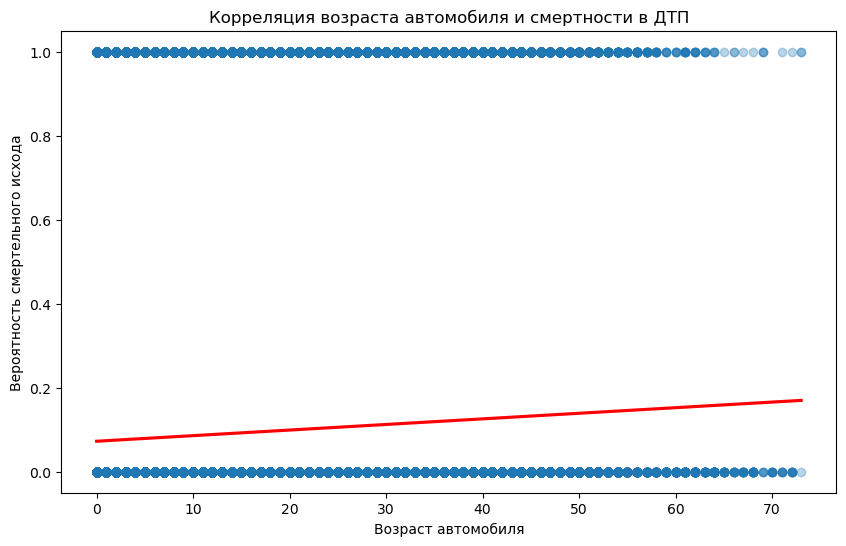

Коэффициент корреляции Пирсона: 0.0363 (p-value: 0)
Коэффициент корреляции Спирмена: 0.0336 (p-value: 0)


In [52]:
import scipy.stats as stats

# Расчет возраста автомобиля
current_year = 2024
expanded_df['vehicle_age'] = current_year - expanded_df['vehicle_year']

# Удаляем строки с NaN в vehicle_age и dead_count
filtered_df = expanded_df.dropna(subset=['vehicle_age', 'dead_count'])
filtered_df = filtered_df.query('vehicle_year > 1950')

# Бинаризация смертности
filtered_df['fatal'] = (filtered_df['dead_count'] >= 1).astype(int)

# Расчет коэффициента корреляции Пирсона
pearson_corr, p_value = stats.pearsonr(filtered_df['vehicle_age'], filtered_df['fatal'])

# Расчет коэффициента корреляции Спирмена
spearman_corr, spearman_p_value = stats.spearmanr(filtered_df['vehicle_age'], filtered_df['fatal'])

# Визуализация
plt.figure(figsize=(10, 6))
sns.regplot(
    x='vehicle_age', 
    y='fatal', 
    data=filtered_df, 
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)
plt.title('Корреляция возраста автомобиля и смертности в ДТП')
plt.xlabel('Возраст автомобиля')
plt.ylabel('Вероятность смертельного исхода')
plt.show()

# Результаты
print(f"Коэффициент корреляции Пирсона: {pearson_corr:.4f} (p-value: {p_value:.4g})")
print(f"Коэффициент корреляции Спирмена: {spearman_corr:.4f} (p-value: {spearman_p_value:.4g})")

Вывод: гипотеза о том, что возраст автомобиля прямо связан с увеличением смертельных исходов в ДТП, не подтверждается. Несмотря на статистическую значимость, величина корреляции слишком мала для практического применения

### Гипотеза №4: Превышение скорости является одной из главных причин смертности и количества ДТП в Чеченской республике.
   
Для ее проверки мы возьмем данные смертельных ДТП в Чечне и посмотрим, в каком % из них превышение скорости заявлено, как нарушение и сравним с аналогичным показателем в СПб.

C:\Users\bobri\AppData\Local\Temp\ipykernel_21212\1787145029.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadly_dtp_regions["speeding_violation"] = deadly_dtp_regions["driver_violations"].str.contains("скорост", case=False, na=False)


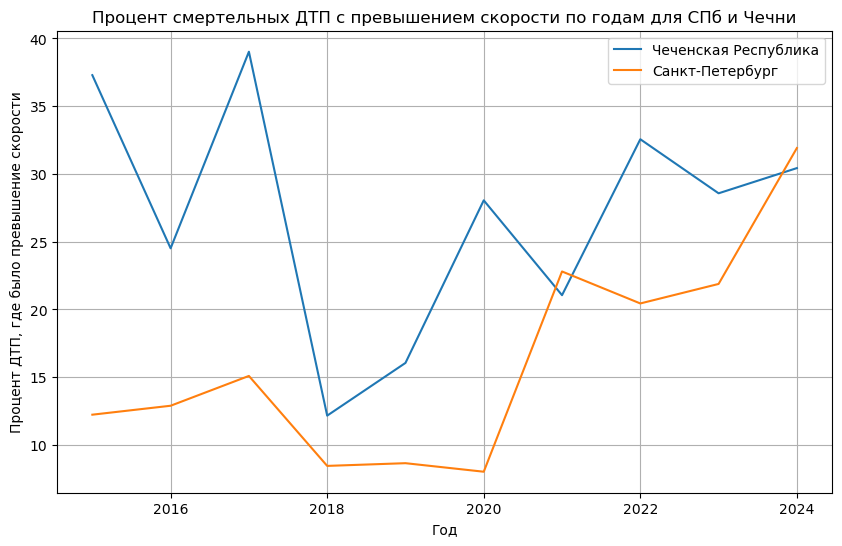

In [53]:
# Фильтруем смертельные ДТП (учитываем все годы)
deadly_dtp_all_years = expanded_df.query("dead_count >= 1")

# Отбираем данные для Чеченской республики и Санкт-Петербурга
regions = ["Чеченская Республика", "Санкт-Петербург"]
deadly_dtp_regions = deadly_dtp_all_years[deadly_dtp_all_years["parent_region"].isin(regions)]

# Определяем превышение скорости
deadly_dtp_regions["speeding_violation"] = deadly_dtp_regions["driver_violations"].str.contains("скорост", case=False, na=False)

# Группировка по году и региону
region_year_summary = (
    deadly_dtp_regions.groupby(["year", "parent_region"])
    .agg(
        total_deadly_dtp=("parent_id", "nunique"),
        speeding_related=("speeding_violation", "sum"),
    )
    .reset_index()
)

# Вычисляем процент превышения скорости
region_year_summary["speeding_percent"] = round(region_year_summary["speeding_related"] / region_year_summary["total_deadly_dtp"] * 100, 2)

# Построение графика
plt.figure(figsize=(10, 6))
for region in regions:
    data = region_year_summary[region_year_summary["parent_region"] == region]
    plt.plot(data["year"], data["speeding_percent"], label=region)

# Настройка графика
plt.xlabel('Год')
plt.ylabel('Процент ДТП, где было превышение скорости')
plt.title('Процент смертельных ДТП с превышением скорости по годам для СПб и Чечни')
plt.legend()
plt.grid(True)
plt.show()


Вывод: в целом, можно сказать, что в Чечне треть смертельных ДТП совершаются с нарушением соосного режима. Данные по СПб меньше, но к 2024 наметился рост. 

Для интереса можно посмотреть на аналогичный показатель по суммарным данным всех регионов

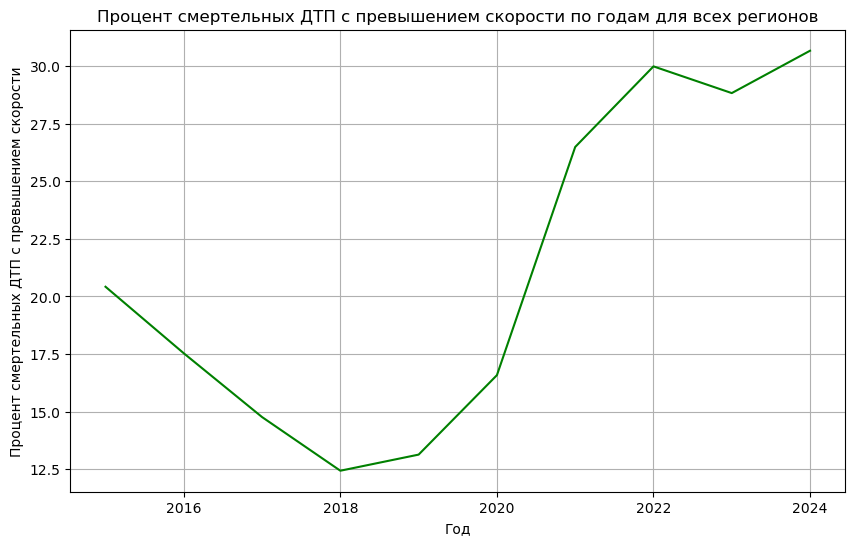

In [54]:
# Фильтруем смертельные ДТП (учитываем все годы)
deadly_dtp_all_years = expanded_df.query("dead_count >= 1")

# Определяем превышение скорости для всех регионов
deadly_dtp_all_regions = deadly_dtp_all_years.copy()
deadly_dtp_all_regions["speeding_violation"] = deadly_dtp_all_regions["driver_violations"].str.contains("скорост", case=False, na=False)

# Группировка по году
all_regions_summary = (
    deadly_dtp_all_regions.groupby("year")
    .agg(
        total_deadly_dtp=("parent_id", "nunique"),
        speeding_related=("speeding_violation", "sum"),
    )
    .reset_index()
)

# Вычисляем процент превышения скорости
all_regions_summary["speeding_percent"] = round(all_regions_summary["speeding_related"] / all_regions_summary["total_deadly_dtp"] * 100, 2)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(all_regions_summary["year"], all_regions_summary["speeding_percent"], color="green")

# Настройка графика
plt.xlabel('Год')
plt.ylabel('Процент смертельных ДТП с превышением скорости')
plt.title('Процент смертельных ДТП с превышением скорости по годам для всех регионов')
plt.grid(True)
plt.show()


Теперь точно можно сказать, что Чечня находится в лидерах по превышению скорости со своими 30% смертельных ДТП. Любопытный общий тренд  - с 2020 года это нарушение выросло вдвое.

Ну и для полноты картины давайте посмотрим на то, какие нарушения лидируют в смертельных ДТП, кроме скорости.


In [55]:
# Посмотрим на уникальные значения в колонке с нарушениями
print(expanded_df['driver_violations'].unique())

['Управление мопедом лицом моложе 16 лет, Управление ТС лицом, не имеющим права на управление ТС, Оставление места ДТП, Невыполнение требований обеспечения безопасности при начале движения'
 nan 'Несоблюдение условий, разрешающих движение транспорта задним ходом'
 ...
 'Нарушение требований сигналов регулировщика, Управление ТС лицом, не имеющим права на управление ТС, Нарушение правил применения мотошлема'
 'Управление ТС в состоянии алкогольного опьянения, Управление ТС лицом, не имеющим соответствующей категории на управление ТС данного вида, Нарушение правил перевозки детей (не использование детских сидений либо удерживающих устройств), Другие нарушения ПДД водителем, Нарушение водителем правил применения ремней безопасности (ставится в случае, когда не пристегнут пассажир)'
 'Нарушение правил перестроения, Управление ТС лицом, не имеющим права на управление ТС, Эксплуатация незарегистрированного ТС, Оставление места ДТП']


C:\Users\bobri\AppData\Local\Temp\ipykernel_21212\2362681364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deadly_dtp_all_years["violations_list"] = deadly_dtp_all_years["driver_violations"].dropna().apply(


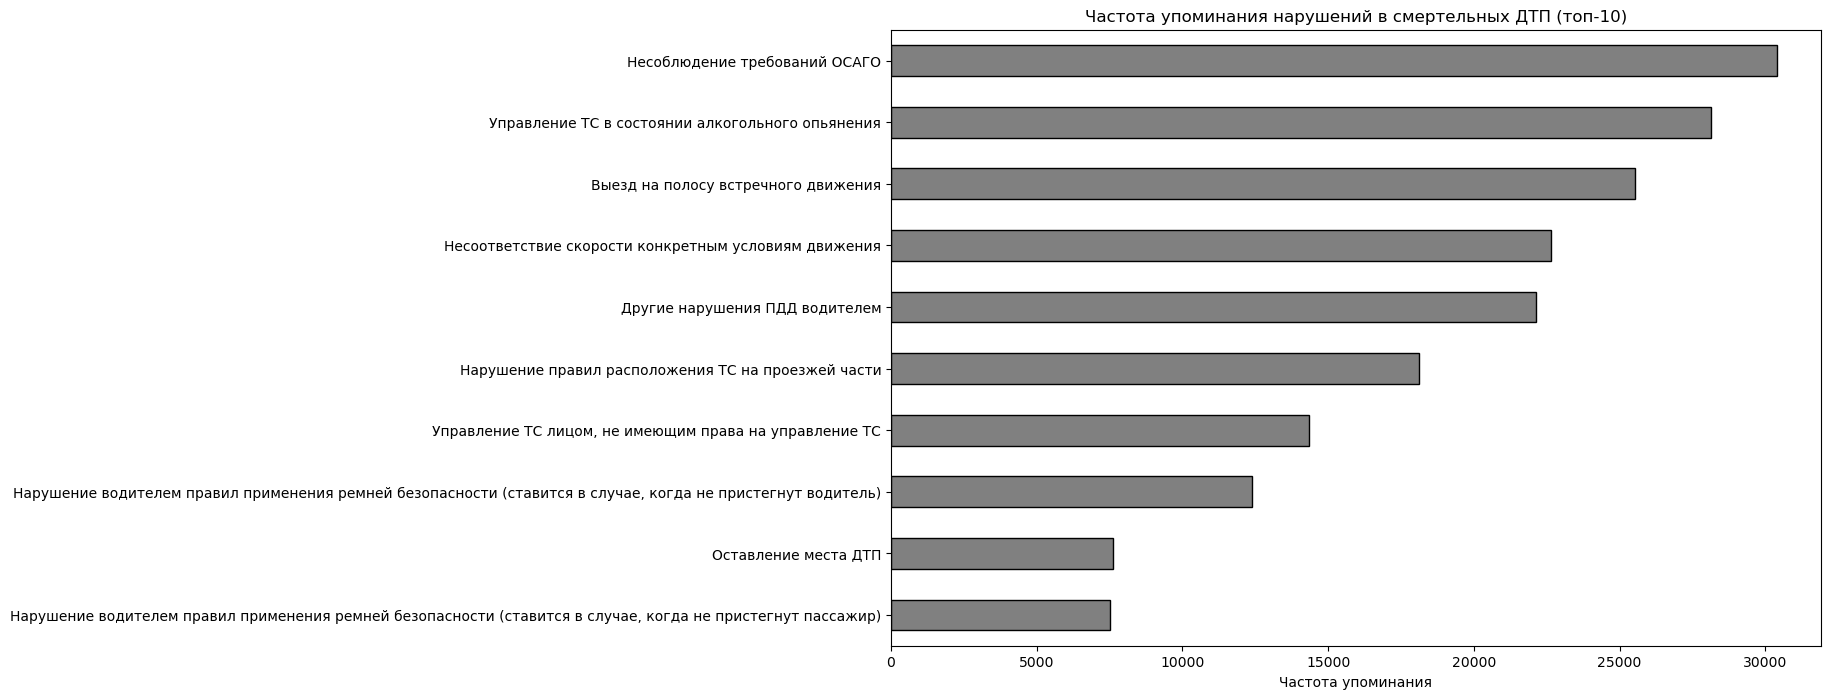

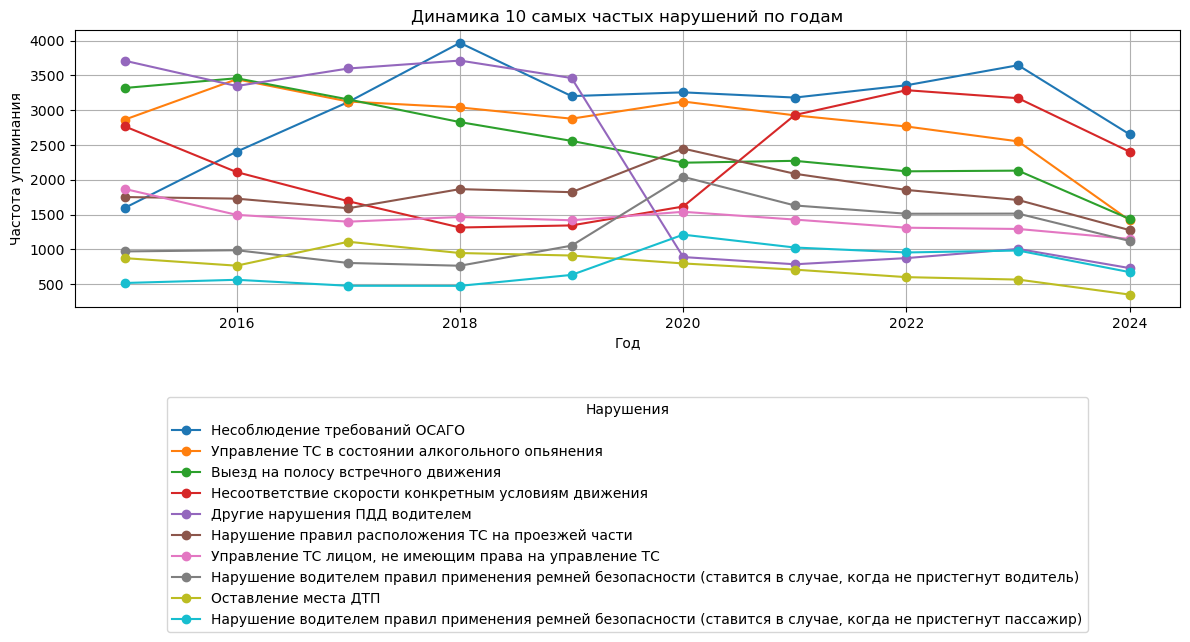

In [56]:
# Разделяем нарушения с помощью регулярного выражения
deadly_dtp_all_years["violations_list"] = deadly_dtp_all_years["driver_violations"].dropna().apply(
    lambda x: re.split(r", (?=[А-Я])", x)
)

# Разворачиваем данные и считаем частоту упоминаний нарушений
violation_counts = (
    deadly_dtp_all_years.explode("violations_list")
    .groupby("violations_list")
    .size()
    .sort_values(ascending=False)
)

# Ограничиваем список до топ-10 нарушений
top_10_violations = violation_counts.head(10)

# Горизонтальный барчарт частоты нарушений
plt.figure(figsize=(12, 8))
top_10_violations.plot(kind="barh", color="grey", edgecolor="black")
plt.xlabel("Частота упоминания")
plt.ylabel("")
plt.title("Частота упоминания нарушений в смертельных ДТП (топ-10)")
plt.gca().invert_yaxis()
plt.show()

# Группировка по годам и нарушениям для топ-10
yearly_violation_trends = (
    deadly_dtp_all_years.explode("violations_list")
    .query("violations_list in @top_10_violations.index")
    .groupby(["year", "violations_list"])
    .size()
    .reset_index(name="count")
)

# Построение графиков для 10 самых частых нарушений
plt.figure(figsize=(12, 10)) 
for violation in top_10_violations.index:
    yearly_data = yearly_violation_trends[yearly_violation_trends["violations_list"] == violation]
    plt.plot(
        yearly_data["year"],
        yearly_data["count"],
        marker="o",
        label=violation
    )

# Настройки графика
plt.xlabel("Год")
plt.ylabel("Частота упоминания")
plt.title("Динамика 10 самых частых нарушений по годам")
plt.legend(
    title="Нарушения",
    bbox_to_anchor=(0.5, -0.3),  # Расположение под графиком
    loc="upper center",
    ncol=1,  # Легенда в 1 колонку
    fontsize=10
)
plt.grid(True)

# Увеличиваем расстояние для легенды снизу
plt.tight_layout(rect=[0, 0.2, 1, 1])  # rect добавляет место под графиком
plt.show()

- как мы выдим из полных данных по всем регионам за весь период - в причинах сметрельных ДТП ТОП-3  (ОСАГО  не берем в счет, ддумаю, это какие-то проблемы с оформленным полисом или его отсутствие, это скорее сопутствующая совершенному ДТП информация)
    - управление в состоянии алкогольного опъянения
    - выезд на встречную полосу
    - превышение скорости

### Гипотеза №5: Мужчины совершают больше ДТП со смертельным исходом, чем женщины

Для проверки гипотезы о том, что мужчины совершают больше ДТП со смертельным исходом, чем женщины, мы будем анализировать количество смертельных ДТП по полам и проверять, есть ли статистически значимая разница между пропорцией с помощью z-теста

Н0: нет статистически значимой разницы между процентом смертельных ДТП, совершаемых мужчинами и женщинами
Н1: Можно утверждать, что такая разница есть

In [57]:
# Фильтруем данные для всех ДТП
total_dtp = expanded_df.groupby('driver_gender')['parent_id'].nunique().reset_index()
# Фильтруем только смертельные ДТП
deadly_dtp = expanded_df[expanded_df['dead_count'] >= 1].groupby('driver_gender')['parent_id'].nunique().reset_index()

# Объединяем данные для подсчета процента
gender_summary = pd.merge(total_dtp, deadly_dtp, on='driver_gender', how='left')
gender_summary['deadly_percent'] = (gender_summary['parent_id_y'] / gender_summary['parent_id_x']) * 100

# Заменяем NaN значения на 0 (если для какого-то пола не было смертельных ДТП)
gender_summary['deadly_percent'] = gender_summary['deadly_percent'].fillna(0)

# Печатаем результаты
print(gender_summary)

# Данные по количеству ДТП и смертельных ДТП
male_total_dtp = gender_summary[gender_summary['driver_gender'] == 'Мужской']['parent_id_x'].values[0]
female_total_dtp = gender_summary[gender_summary['driver_gender'] == 'Женский']['parent_id_x'].values[0]

male_deadly_dtp = gender_summary[gender_summary['driver_gender'] == 'Мужской']['parent_id_y'].values[0]
female_deadly_dtp = gender_summary[gender_summary['driver_gender'] == 'Женский']['parent_id_y'].values[0]

# Доли смертельных ДТП для мужчин и женщин
p_male = male_deadly_dtp / male_total_dtp
p_female = female_deadly_dtp / female_total_dtp

# Общая доля смертельных ДТП
p_pool = (male_deadly_dtp + female_deadly_dtp) / (male_total_dtp + female_total_dtp)

# Количество наблюдений
n_male = male_total_dtp
n_female = female_total_dtp

# z-статистика
z = (p_male - p_female) / np.sqrt(p_pool * (1 - p_pool) * (1/n_male + 1/n_female))

# p-значение для двухстороннего теста
p_value = 2 * (1 - norm.cdf(abs(z)))

# Вывод результатов
print(f"z-статистика: {z}")
print(f"p-значение: {p_value}")


  driver_gender  parent_id_x  parent_id_y  deadly_percent
0       Женский       310123        15143            4.88
1       Мужской      1318476       133133           10.10
z-статистика: 90.82735799620556
p-значение: 0.0


Вывод: результаты показали, что z-статистика равна 90.83, а p-значение равно 0, что говорит о сильной статистической значимости различия между процентами смертельных ДТП для мужчин и женщин.

Это означает, что гипотеза, что мужчины совершают больше смертельных ДТП по сравнению с женщинами, имеет статистически значимое подтверждение (отвергаем Н0)

### Визуализация самых опасных мест по количеству ДТП

Возьмем регион, лидирующий по % смертельных ДТП - **Чеченскую Республику**- и посмотрим, как на карте расположены точки, где эти ДТП происходят. Может, есть особенно опасные места, где надо поставить светофоры или поменять схему движения?

In [58]:
# Фильтрация данных для региона с учетом погибших
filtered_data = all_data_united.query('parent_region == "Чеченская Республика" and dead_count >= 1')

# Преобразуем 'point' в строку (или кортеж), чтобы использовать в группировке
filtered_data['point_str'] = filtered_data['point'].apply(lambda x: f"{x['lat']},{x['long']}" if isinstance(x, dict) else None)

# Группировка по преобразованным строкам с агрегацией, включая информацию по адресу и году
top_addresses = filtered_data.groupby('point_str').agg(
    accident_count=('point', 'count'),
    total_dead_count=('dead_count', 'sum'),
    year=('year', 'unique'),
    address=('address', 'unique')
).reset_index()

# Извлечение координат из строки (разделяем по запятой)
top_addresses[['lat', 'lon']] = top_addresses['point_str'].str.split(',', expand=True)
top_addresses['lat'] = top_addresses['lat'].astype(float)
top_addresses['lon'] = top_addresses['lon'].astype(float)

# Удаление записей с NaN координатами
top_addresses = top_addresses.dropna(subset=["lat", "lon"])

# Проверка на наличие данных после фильтрации
if top_addresses.empty:
    raise ValueError("Нет корректных данных для отображения на карте.")

# Сортировка по количеству ДТП и выборка топ-10 самых опасных мест
top_10_addresses = top_addresses.sort_values(by='accident_count', ascending=False).head(10)

# Создание карты с использованием Folium
center_lat = top_10_addresses["lat"].mean()
center_lon = top_10_addresses["lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Выводим информацию о топ-10 самых опасных местах через print
print("Топ-10 самых опасных мест (по количеству ДТП):")
for _, row in top_10_addresses.iterrows():
    address_list = ', '.join(row['address'])  # список адресов
    years = ', '.join(map(str, row['year']))  # годы ДТП
    print(f"Адреса: {address_list}")
    print(f"Годы ДТП: {years}")
    print(f"Количество ДТП: {row['accident_count']}")
    print(f"Количество погибших: {row['total_dead_count']}")
    print("-" * 50)

# Добавление маркеров для топ-10 самых опасных мест
for _, row in top_10_addresses.iterrows():
    folium.Marker(
        location=[row["lat"], row["lon"]],
        popup=f"Количество ДТП: {row['accident_count']}<br>Количество погибших: {row['total_dead_count']}",
        tooltip=f"Точка: {row['lat']}, {row['lon']}",
    ).add_to(m)

# Отображение карты
m


c:\Users\bobri\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Топ-10 самых опасных мест (по количеству ДТП):
Адреса: Р-217 Кавказ автомобильная дорога М-4 Дон - Владикавказ - Грозный - Махачкала - граница с Азербайджанской Республикой (основное направление), 630 км, Р-217 Кавказ автомобильная дорога М-4 Дон - Владикавказ - Грозный - Махачкала - граница с Азербайджанской Республикой (основное направление), 631 км, Грозный-Ведено-гр.Дагестана, 5 км, Ищерск-Грозный, 4 км
Годы ДТП: 2015
Количество ДТП: 5
Количество погибших: 8
--------------------------------------------------
Адреса: Грозный-Шатой-Итум-Кали-п.з.Аргун-гр.Грузии, 23 км, Грозный-Шатой-Итум-Кали-п.з.Аргун-гр.Грузии, 25 км, г Грозный, ул Химиков
Годы ДТП: 2015
Количество ДТП: 3
Количество погибших: 4
--------------------------------------------------
Адреса: Червленная-Грозный, 15 км, Подъезд от а/д Червленная-Грозный к с.Толстой-Юрт, 14 км, Грозный-Шатой-Итум-Кали-п.з.Аргун-гр.Грузии, 10 км
Годы ДТП: 2016
Количество ДТП: 3
Количество погибших: 5
-----------------------------------------

## Итоги:

В рамках исследования данных о ДТП в РФ за период 2015- 2024 годы мы сделали следующие шаги и обнаружили определенные закономерности:

1. Импортированы с сайта заказчика и подготовлены для анализа данные о ДТП во всех 85 регионах РФ
2. Выполнены необходимые проверки на дубликаты и пропуски, заменены некоторые типы данных для оптимизации производительности работы с ними
3. Из колонок vehicles & participants, имеющих вид списка словарей, выделены данные, необходимые для нашего исследования, сформирована сводная таблица с ключевой информаций по каждому ДТП
4. Проведен статистический анализ данных и обнаружены следующие важные закономерности в них:
    - около 10% ДТП совершаются с участием детей, 1% - с участием пешеходов
    - более 60% ДТП совершается в светлое время суток и хорошую погоду
    - лидирующий тип ДТП - столкновение (более 47%), 57% ДТП имеют легкую тяжесть, 33.3% тяжелые и 9.52% - с погибшими
    - преобладающий возраст машин в ДТП 10-20 лет, любопытный провал с машинами 2009 года выпуска - их в 2 раза меньше, чем в 2008 и 2010
    - Наблюдается плавное снижение количества ДТП после водительского стажа в 10 лет
    - Количество ДТП планомерно снижалось до 2022. В 2023 опять наблюдается рост, данные 2024 года (до сентября) говорят о снижении
    - Сезонность: лето и начало осенни - (июнь-октябрь) лидируют по количеству ДТП
    - Дни недели: пятница и суббота опаснее остальных дней, судя по большему количеству ДТП
    - По времени суток: пик ДТП приходится на 17-19 часов, а больше смертельных приходятся на период 18-21 час
    - Исторические лидеры по смертности в ДТП - южные регионы (Чечня, Ингушетия, Дагестан, Кабардино-Балкария, Адыгея).
    - Наибольшее количество ДТП совершаются с участием категорий легковых автомобилей В, С, D-классов и мотоциклов. А наибольший % смертельных - с участием грузовиков, спецтехники
    - Топ-3 нарушения, приводящих к смертельным ДТП:
        - управление в состоянии алкогольного опьянения
        - выезд на встречную полосу
        - превышение скорости
5. Формулирования и проверка гипотез:
- Количество ДТП со смертельными исходами составляет в среднем 10% от общего количества ДТП
- Средний водительский стаж для большинства ДТП - 10 лет
- Возраст авто и смертность в ДТП - есть прямая корреляция (чем выше возраст авто тем больше ДТП со смертельным исходом)
- Превышение скорости является одной из главных причин смертности и количества ДТП в Чеченской республике   
- Мужчины совершают больше ДТП со смертельным исходом, чем женщины

Результаты доступны в виде презентации по ссылке:  
https://docs.google.com/presentation/d/1wZilNSiFy87mHMoKp50yGQlGE9ttNWJ8HPrnWoyOsbo/edit?usp=sharing
